# Thesis Figures

# Set up Notebook

In [90]:
import os
#Specify whether to use CHEESEHEAD or synthtic data 
os.environ['config'] = 'CHEESEHEAD'
# os.environ['config'] = 'synthetic'

#Import setup module
from setup import* 
from chad_funcs import *

import fsspec
import xarray as xr
import geopandas as gpd 
import geodatasets
import contextily as cx

#If using limited cases- full case list read in through setup module
cases = pd.read_csv('../Inputs/cases_limited.csv', index_col = 'case') #dataframe of tower coordinates

In [91]:
colorlist = ["#1F4E79", "#AD403D", "xkcd:grey", "#2E75B6","#CB6D6B","#BDD7EE", "#DB9B99", "xkcd:ocean blue", "xkcd:terracotta", "xkcd:magenta", "xkcd:blue green", "xkcd:grey", "xkcd:sky blue", "xkcd:light orange",
             "xkcd:grey blue", "xkcd:dark yellow", "xkcd:pale purple", "xkcd:coral",
              "xkcd:light olive", "xkcd:reddish brown", "xkcd:dark lavender", "xkcd:forrest green", 
             "xkcd:light cyan", "xkcd:orchid", "xkcd:puke yellow", "xkcd:periwinkle blue", "#CF7B67"]

## Date stuff

In [92]:
startdate = dt.datetime(2019, 6, 20)
enddate = dt.datetime(2019, 10, 13, 23, 30)
dtindex = readdata('dtindex', startdate, enddate)
hh_index = np.arange(0, 24, 0.5) #half-hourly index

In [93]:
#Dataset parameters
case = 'A' #Currently using case 1 (interp, 1000m, updown, thin_plate_spline, Benoit)
towsmin = 15 #minimum number of towers

In [94]:
towplotlist = ['PFb', 'PFe', 'PFg', 'PFh', 'PFi', 'PFj', 'PFk',
       'PFm', 'PFn', 'PFp', 'PFq', 'PFt']

## Functions

In [95]:
#Function to mean diurnal cycle
def day_cyc(dat):
    dat_day = dat.groupby(dat.index.time).mean()
    return dat_day

In [96]:
def nanfilt(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_f = x[mask]
    y_f = y[mask]
    
    return x_f, y_f

# Read in/set up data 


In [97]:
#Horizontal wind
hrz_wind = readdata('hrz_wind', startdate, enddate) #Horizontal wind- includes WS_top, WD

#MO length
MO = readdata('MO', startdate, enddate)

#zeta
zeta = readdata('zeta', startdate, enddate)

#Vertical wind
w_son = readdata('w_son', startdate, enddate)
w_cont = readdata('w_cont', startdate, enddate)

#Energy budget components
E_budget = pd.read_pickle(input_filepath + 'Cons_input_data/E_budget.pickle')

#Nans
nanmask = pd.read_pickle(intermed_filepath + 'nandat/trac_nanmask.pickle')
nancount = pd.read_pickle(intermed_filepath + 'nandat/trac_nancount.pickle')

#Met data
TA = readdata('TA', startdate, enddate)
H2O =  readdata('H2O', startdate, enddate)

In [98]:
#Read in advection data
filepath = output_filepath + 'adv_final/H_hrz_all_lai.pickle'
H_hrz = pd.read_pickle(filepath)

filepath = output_filepath + 'adv_final/LE_hrz_all_lai.pickle'
LE_hrz = pd.read_pickle(filepath)

filepath = output_filepath + 'adv_final/vert_ad_son.pickle'
vert_ad_son = pd.read_pickle(filepath).apply(pd.to_numeric, errors='coerce')

filepath = output_filepath + 'adv_final/vert_ad_son_abs.pickle'
vert_ad_son_abs = -pd.read_pickle(filepath).apply(pd.to_numeric, errors='coerce')

filepath = output_filepath + 'adv_final/vert_ad_cont_lai.pickle'
vert_ad_cont = pd.read_pickle(filepath)

### Consolidate advection data

In [99]:
#Create dataframe to hold data filtered for when at least 10 towers have data
adv_nanfilt = make_multi_df([['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert'], towlist], ['var', 'tow'], dtindex)

#Add each advection term  
adv_nanfilt['H_hrz'] = H_hrz[case].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['LE_hrz'] = LE_hrz[case].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['H_vert'] = vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['LE_vert'] = vert_ad_son['LE'].where(nancount.max(axis = 1)<=towsmin)

### Energy residuals

In [100]:
#Energy residuals
E_res_na_all = E_budget.Rnet - E_budget.G - E_budget.H_turb - E_budget.LE_turb - E_budget.SH - E_budget.SLE  + E_budget.SG
#Need to figure out SG sign (seems like it is reversed from other terms
E_res_wa = E_res_na_all - adv_nanfilt['H_hrz'] - adv_nanfilt['LE_hrz'] - adv_nanfilt['H_vert'] - adv_nanfilt['LE_vert']
E_res_na = E_res_na_all.where(E_res_wa.notnull()) #filter only for times when E_res_wa has values

In [101]:
E_res_na_perc = E_res_na/(E_budget.Rnet + E_budget.G)
E_res_wa_perc = E_res_wa/(E_budget.Rnet + E_budget.G)

### Available Energy

In [102]:
#available energy 
AE = E_budget.Rnet - E_budget.G - E_budget.SH - E_budget.SLE  #+E_budget.SG?

In [103]:
#Filter for advection > AE
# adv_nanfilt_AEfilt = 

## Bowen Ratio

In [104]:
BR_turb = E_budget.H_turb/E_budget.LE_turb
BR_adv = (adv_nanfilt.H_hrz + adv_nanfilt.H_vert)/(adv_nanfilt.LE_hrz + adv_nanfilt.LE_vert)

# Plots

In [105]:
#Select data to use
adv_use = adv_nanfilt

### 10 hz Plot

In [106]:
df_w = pd.DataFrame(index = dtindex, columns = tc.wind_var)
ts_s = pd.Series(data = dtindex.strftime('%m%d_%H'), index = dtindex)


d = 20
h = 16
startcut = dt.datetime(2019, 8, d, h)
endcut = dt.datetime(2019, 8, d, h + 3)
dtindex_cut = readdata('dtindex', startcut, endcut)
w_flat = np.empty(0)
for hour in dtindex_cut[: -1]:
    if hour.minute == 0:
        print(hour)

        url = 'http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/ISFS/high-rate/isfs_geo_hr_2019' +ts_s.loc[hour] + '.nc'
        with fsspec.open(url) as fobj:
            ds = xr.open_dataset(fobj)

        w_flat = np.append(w_flat, ds[tc.wind_var.iloc[5]].values.ravel())

2019-08-20 16:00:00
2019-08-20 17:00:00
2019-08-20 18:00:00


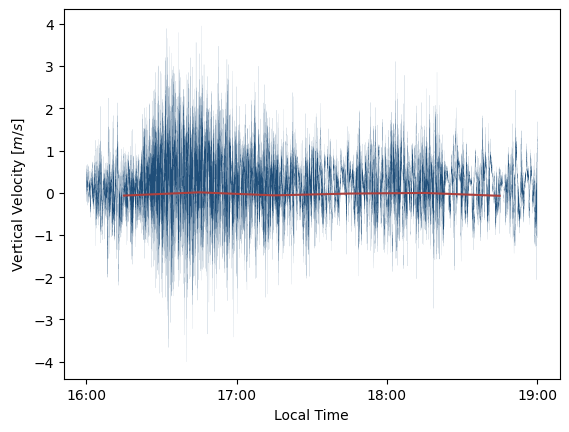

In [107]:
hr_vals = h + np.array(range(len(w_flat)))/(20*60*60)
plt.plot(hr_vals, w_flat, linewidth = 0.05, c = colorlist[0])
plt.xlabel('Local Time')
plt.ylabel('Vertical Velocity [$m/s$]')
hours = w_son['PFg'][startcut:endcut].index.hour + w_son['PFg'][startcut:endcut].index.minute/60 + 0.25
plt.plot(hours[:-1], w_son['PFg'][dtindex_cut].values[:-1], c = colorlist[1])
plt.xticks(ticks = [16, 17, 18, 19], labels = ['16:00', '17:00', '18:00', '19:00']);

plt.savefig('../../Thesis_materials/20hz_w.png')

### Site Map

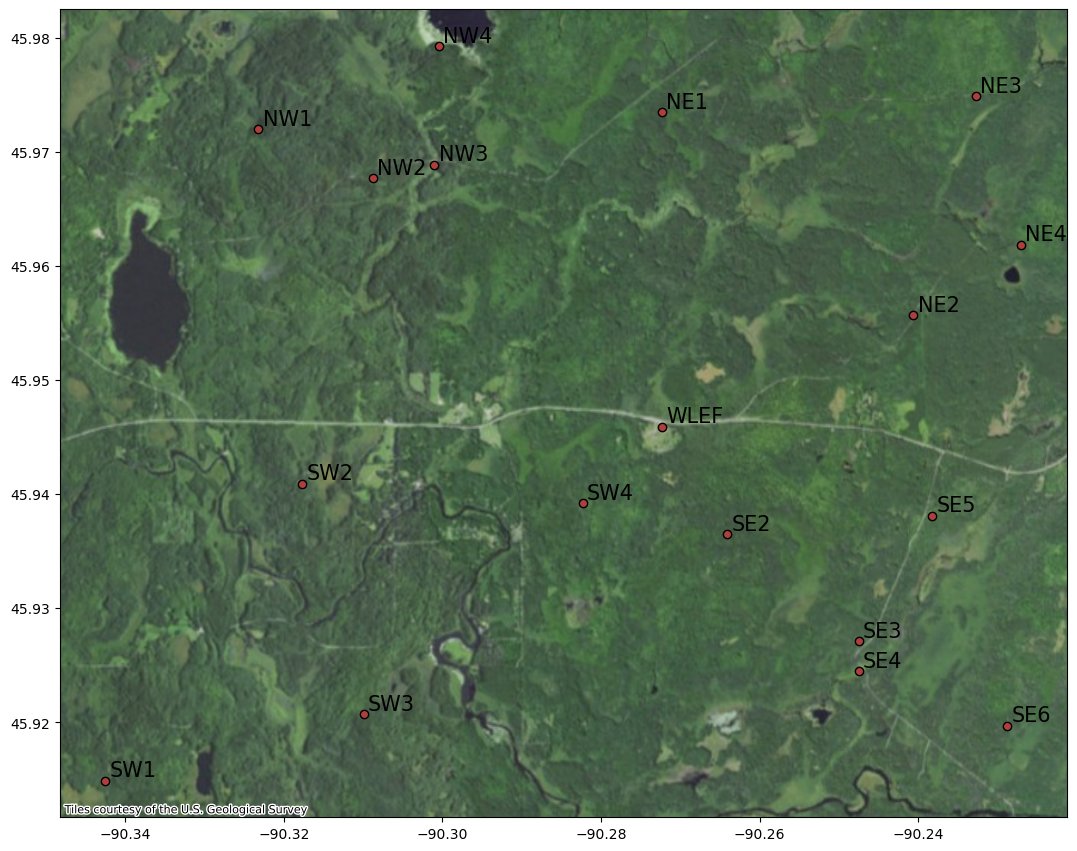

In [108]:
filepath = 'C:\\Users\\emily\\Documents\\Grad_School\\Research\\CHAS\\Analysis\\Inputs\\ameriflux-site-search.kml'
# filepath = 'C:\Users\emily\Documents\Grad_School\Research\CHAS\Analysis\Inputs
df = gpd.read_file(filepath)

df_wm = df.to_crs(epsg=3857)
df_wm = df.to_crs(epsg=4326)

CH_sites = df_wm[df_wm["Name"].str.contains("US-PF")].drop([437, 446]) #Take cheesehead sites but not PFf and PFo

ax = CH_sites.plot(figsize=(13, 13), color=colorlist[1], edgecolor = 'k')
cx.add_basemap(ax, source=cx.providers.USGS.USImagery, crs='EPSG:4326')


for x, y, label in zip(CH_sites.geometry.x, CH_sites.geometry.y, tc.dir_names):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize =15, c = 'k')
    
x_c, y_c = CH_sites.loc[432].geometry.x, CH_sites.loc[432].geometry.y

plt.savefig('../../Thesis_materials/site_map.png')

# # Customize the x-axis ticks: Convert to km and adjust relative to x_c
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{(x - x_c)/1000:.0f}'))

# # Customize the y-axis ticks: Convert to km and adjust relative to y_c
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{(y - y_c)/1000:.0f}'))


## Interp Methods Plots

In [109]:
# startdate_cut = dt.datetime(2019, 7, 18)
# enddate_cut = dt.datetime(2019, 7, 19)
# plt.plot(WD.isna().sum(axis = 1)[startdate_cut:enddate_cut])
# plt.xticks(rotation = 45);

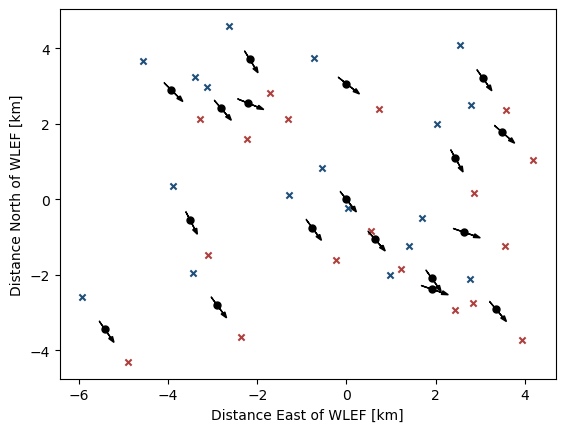

In [110]:
#Horizontal Interpolation method
WD = hrz_wind['WD']
plotdate = dt.datetime(2019, 7, 20, 18)
# plotdate = dt.datetime(2019, 7, 20, 12)

#Get coordinates for interpolation points and ends of arrow
interpcoords = updowncoords(1000, WD, tc).loc[plotdate]
windarrowcoords = updowncoords(250, WD, tc).loc[plotdate] #change first parameter to change length of arrow

#Set fig dimensions
# plt.figure(figsize = (6, 6))
# plt.xlim(-6, 5);
# plt.ylim(-6, 5);
    

#Plot towers as black points
plt.scatter(tc.x/1000, tc.y/1000, c = 'k', s = 25, marker = 'o')

#Plot up and downwind 
plt.scatter(interpcoords.loc[: ,'up', 'x']/1000, interpcoords.loc[: ,'up', 'y']/1000, c = colorlist[0], marker = 'x', s = 20)
plt.scatter(interpcoords.loc[: ,'down', 'x']/1000, interpcoords.loc[: ,'down', 'y']/1000, c = colorlist[1], marker = 'x', s = 20)

for tow in towlist:
    plt.arrow(windarrowcoords.loc[tow ,'up', 'x']/1000, windarrowcoords.loc[tow ,'up', 'y']/1000, 
              windarrowcoords.loc[tow ,'down', 'x']/1000 - windarrowcoords.loc[tow ,'up', 'x']/1000, 
              windarrowcoords.loc[tow ,'down', 'y']/1000 - windarrowcoords.loc[tow ,'up', 'y']/1000,
             head_width = .1, facecolor = 'k')
    
plt.xlabel('Distance East of WLEF [km]');
plt.ylabel('Distance North of WLEF [km]');


plt.savefig('../../Thesis_materials/hrz_interp_methods_map.png')

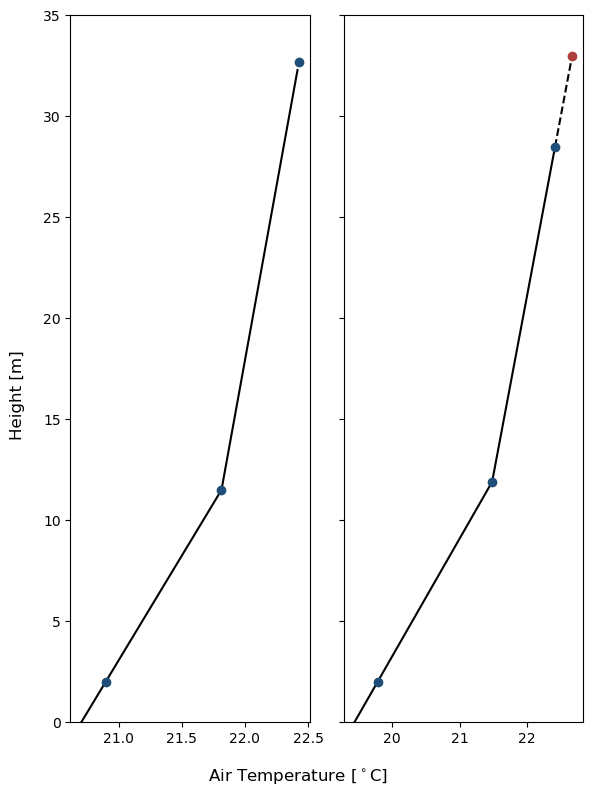

In [111]:
fig, axs = plt.subplots(1, 2, figsize = [6, 8], sharey=True)
plt.ylim(0, 35);
fig.supylabel('Height [m]')
fig.supxlabel('Air Temperature [$^\circ$C]')
plotdate = dt.datetime(2019, 8, 20, 18)

#Plot regular 
tow = 'PFe'
dat = TA

T_prof = prof_calcs(tow, dat, 'mes', dtindex, step = 0.1)
axs[0].plot(T_prof.loc[plotdate], T_prof.loc[plotdate].index, c= 'k')
axs[0].scatter(dat.loc[plotdate][:, tow], get_zs('mes', tow), c = colorlist[0], zorder = 2)

#Plot regular 
tow = 'PFl'
dat = TA

T_prof = prof_calcs(tow, dat, 'mes', dtindex, step = 0.1)
axs[1].plot(T_prof.loc[plotdate], T_prof.loc[plotdate].index, c= 'k', zorder = 1)
axs[1].plot([T_prof.loc[plotdate][28.5],dat.loc[plotdate][:, tow][30]],
            [28.5, get_zs('mes', tow)[2]], c= 'k', zorder = 1, linestyle = '--')

axs[1].scatter(dat.loc[plotdate][:, tow][0:2], get_zs('mes', tow)[0:2], c = colorlist[0], zorder = 2)

axs[1].scatter(T_prof.loc[plotdate][28.5], 28.5, zorder = 2, c = colorlist[0])
axs[1].scatter(dat.loc[plotdate][:, tow][30], get_zs('mes', tow)[2], zorder = 2, c = colorlist[1])
plt.tight_layout()

plt.savefig('../../Thesis_materials/vert_prof_interp_methods.png')

## Magnitude of and Relationships Between Advective Flux Components

In [112]:
adv_means = pd.DataFrame(index = towlist)
perc_means = pd.DataFrame(index = towlist)

adv_total = adv_use.T.groupby(level='tow').sum(min_count=4).T

adv_comps = ['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert']

for comp in adv_comps:
    # adv_means[comp] = adv_nanfilt[comp].mean()
    # perc_means[comp] = adv_nanfilt[comp].std()
    
    adv_means[comp] = adv_use[comp].median()
    perc_means[comp] = (adv_use[comp]/AE*100).median()
    
adv_means['Total'] = adv_total.median()
perc_means['Total'] = (adv_total/AE*100).median()

# adv_means['Total'] = adv_total.mean()
# perc_means['Total'] = adv_total.std()

# adv_means['AE'] = AE.mean()
# perc_means['AE'] = AE.std()

adv_table = adv_means.round(2).astype(str) + ' (' + perc_means.round(2).astype(str) + ')'
adv_table.to_csv('../../Thesis_materials/adv_mag_perc_table.csv')

adv_table

H_hrz         LE_hrz         H_vert         LE_vert  \
Tower                                                                
PFA      -0.39 (nan)      1.1 (nan)      nan (nan)       nan (nan)   
PFb    -0.31 (-0.17)    1.88 (1.18)   31.53 (0.63)  -14.1 (-13.62)   
PFc    -0.13 (-0.06)    0.04 (0.45)   -4.01 (3.57)    12.3 (12.58)   
PFd    -0.15 (-0.12)    0.12 (0.29)      nan (nan)       nan (nan)   
PFe     -1.85 (0.24)    2.52 (1.37)  -14.23 (3.13)    -3.43 (5.59)   
PFg      -1.35 (0.1)    4.23 (0.47)   8.58 (-2.45)   1.57 (-10.85)   
PFh     1.03 (-0.09)  -0.13 (-0.45)    1.4 (-0.88)     0.03 (0.06)   
PFi     0.68 (-0.51)   0.79 (-2.13)   -0.63 (0.08)     4.65 (5.85)   
PFj     1.14 (-0.55)  -1.07 (-1.61)    0.54 (0.64)     0.14 (0.05)   
PFk    -0.03 (-0.02)   -0.81 (0.22)   -0.54 (0.45)    0.22 (-0.74)   
PFl     0.86 (-0.28)  -0.28 (-0.98)   -3.49 (3.45)      8.49 (1.8)   
PFm     0.56 (-0.41)  -1.09 (-0.05)   7.46 (-11.6)   -2.96 (-7.61)   
PFn     0.15 (-0.28)  -0.51 (-0.77)  0.23 (-10.34)  -30.63 (-5.06)   
PFp      -0.13 (0.1)   1.19 (-0.28)  -3.91 (-0.68)    -6.83 (-6.8)   
PFq     0.14 (-0.05)    4.01 (-0.4)   -2.53 (2.28)    -0.07 (0.07)   
PFr     -0.06 (0.03)   -0.06 (0.02)      nan (nan)       nan (nan)   
PFs     0.06 (-0.09)   0.06 (-0.06)    0.77 (3.83)     1.63 (4.69)   
PFt     0.32 (-0.14)   0.88 (-0.18)   -1.56 (1.95)    3.57 (10.26)   

                 Total  
Tower                   
PFA          nan (nan)  
PFb     -0.39 (-15.76)  
PFc       5.31 (23.51)  
PFd          nan (nan)  
PFe      -13.79 (19.9)  
PFg     13.06 (-18.65)  
PFh       3.33 (-3.29)  
PFi       13.08 (9.82)  
PFj       -0.6 (-0.43)  
PFk       -1.54 (4.74)  
PFl      -0.55 (15.85)  
PFm      8.14 (-44.68)  
PFn    -20.14 (-40.21)  
PFp     -10.25 (-5.31)  
PFq        1.43 (5.89)  
PFr          nan (nan)  
PFs        2.28 (9.25)  
PFt       0.07 (19.87)

In [113]:
adv_total.stack().mean(), adv_total.stack().std(), E_res_na.stack().mean()

(-4.613956099230008, 145.8388725790137, 20.54099451593247)

In [114]:
adv_total.mean().min(), adv_total.mean().max()
print(adv_total.mean())

tow
PFA          NaN
PFb     8.233871
PFc     1.563735
PFd          NaN
PFe   -78.987025
PFg    23.405510
PFh    23.993435
PFi    28.272653
PFj     4.855770
PFk   -10.636021
PFl     1.748243
PFm    30.137778
PFn   -68.870866
PFp   -32.035531
PFq    -4.734723
PFr          NaN
PFs     5.978583
PFt    -1.211112
dtype: float64


In [115]:
adv_comps = ['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert']
for comp in adv_comps:
    print(comp, adv_use[comp].stack().mean(), ', ', adv_use[comp].stack().std() )

H_hrz 0.15200563809186218 ,  4.775654334515456
LE_hrz 0.8193693311154546 ,  8.394976677617196
H_vert -1.8599182044688916 ,  74.95833517785424
LE_vert -4.136834418451352 ,  114.90119281968794


### Box plot of advection components

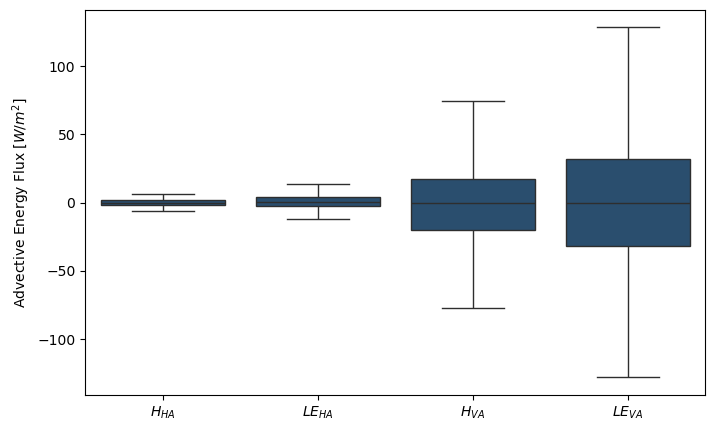

In [116]:
df_melted = adv_nanfilt.melt(value_name="Value")
# hrz_melted = adv_nanfilt[['H_hrz', 'LE_hrz']].melt(value_name = "Value")
# vert_melted = adv_nanfilt[['H_vert', 'LE_vert']].melt(value_name = "Value")

plt.figure(figsize=(8, 5))
sns.boxplot(x="var", y="Value", data=df_melted, showfliers=False, color = colorlist[0])  # Hides outliers

plt.ylabel("Advective Energy Flux [$W/m^2$]")
plt.xlabel('')
plt.xticks(['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert'], ['$H_{HA}$', '$LE_{HA}$', '$H_{VA}$', '$LE_{VA}$'])

# plt.title("")
plt.savefig('../../Thesis_materials/adv_comps_boxplot.png')
plt.show()

In [117]:
# H_hrz_flat = adv_nanfilt['H_hrz'].stack(future_stack=True).reset_index()[0]

# sns.boxplot(x='Advective Flux Component', y='Advective Flux Value', data=H_hrz_flat, color = colorlist[0])

In [118]:

# boxplot_data = []
# for idx, row in y_grpd.iterrows():
#     for value in row['0']:
#         boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
# boxplot_df = pd.DataFrame(boxplot_data)
        
# fig, axs = plt.subplots(figsize=(10,5))
# sns.boxplot(ax = axs, x='Bin', y='Value', data=boxplot_df, color = colorlist[0])

# axs.set_xlabel('$z/L$')
# axs.set_ylabel('Energy Imbalance [$W/m^2$]')
# axs.set_ylim(-400, 425)
# axs.tick_params(axis='x', labelrotation=45);

# #u* boxplots


# x = hrz_wind['Ustar']
# y = adv_total



# #Find bin edges
# x_lin = x.stack(future_stack=True).reset_index()[0]
# bins_list = [x_lin.quantile(0)]
# for i in np.arange(.1, 1, .1):
#     bins_list.append(x_lin.quantile(i))
    
# bins_list.append(x_lin.quantile(1))

# bins_array = np.array(bins_list)

# # Create bins 
# bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)


# y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
# y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')


# boxplot_data = []
# for idx, row in y_grpd.iterrows():
#     for value in row['0']:
#         boxplot_data.append({'Bin': row[0], 'Value': value})
        
# # Convert to DataFrame
# boxplot_df = pd.DataFrame(boxplot_data)

# plt.tight_layout()
# # plt.savefig('../../Thesis_materials/atm_var_boxplot.png')




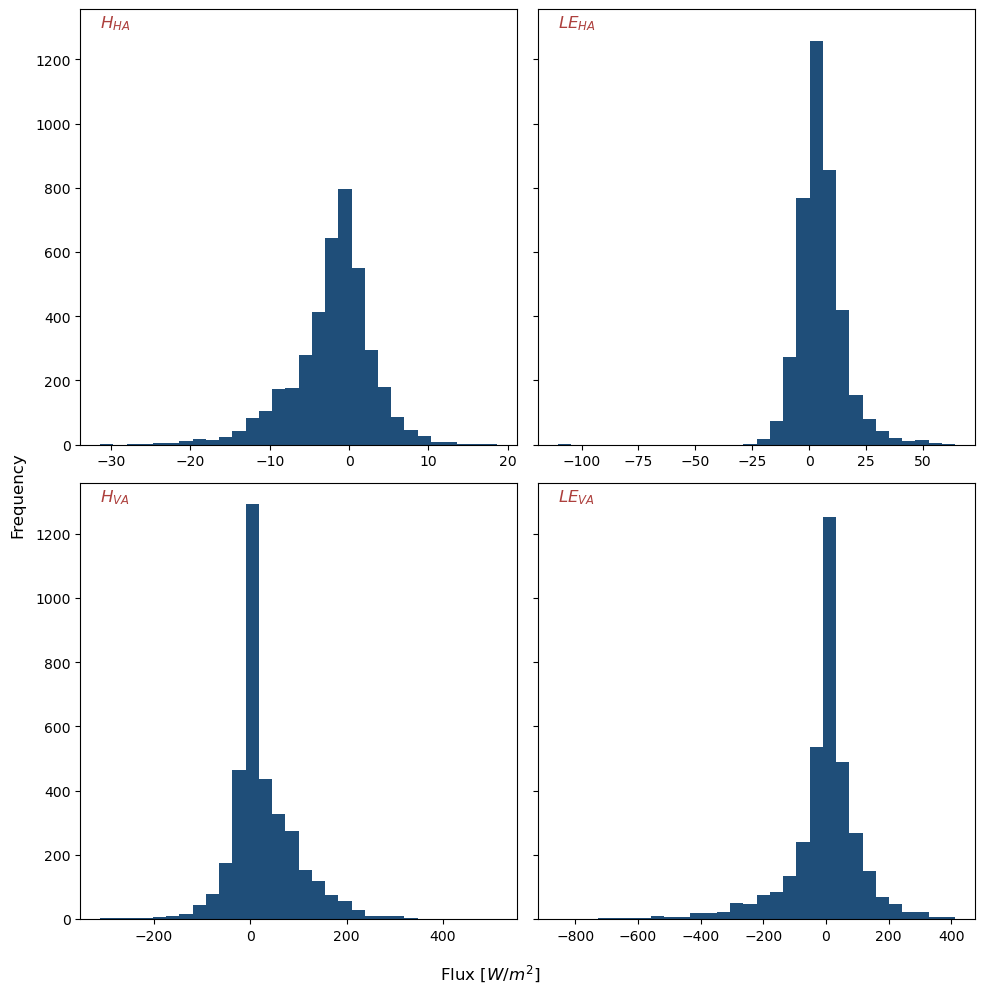

In [ ]:
# # Histograms
# tow = 'PFg'
# fig, axs = plt.subplots(2, 2, figsize = (10, 10), sharey = True)
# comp_lab_list = ['$H_{HA}$', '$LE_{HA}$', '$H_{VA}$', '$LE_{VA}$']
# for i in range(4):
#     comp = adv_comps[i]
#     ax = axs[i//2, i%2]
#     ax.hist(adv_use[comp][tow], bins = 30, color = colorlist[0])
#     ax.annotate(comp_lab_list[i], (adv_use[comp][tow].min(), 1300), size = 12,  c =colorlist[1] )
    
# fig.supxlabel('Flux [$W/m^2$]')
# fig.supylabel('Frequency')
# plt.tight_layout()
# plt.savefig('../../Thesis_materials/comp_hist.png')

In [120]:
vertall = adv_nanfilt['H_vert'] + adv_nanfilt['LE_vert']
vert_big = vertall.abs()>AE.abs() #total vertical advection greater in magnitude than available energy
H_vert_big = adv_nanfilt['H_vert'] >AE.abs() #Just horizontal advection, true when bigger than AE
AE_big = AE.abs()>vertall.abs() #When AE> total vertical advection

vert_big.sum().sum()/(vert_big.sum().sum() + AE_big.sum().sum())

0.38026666666666664

H R2:  0.00010954540628157889 -0.14707837325409545
LE R2:  0.0012338933714001149 -0.45083029964487703


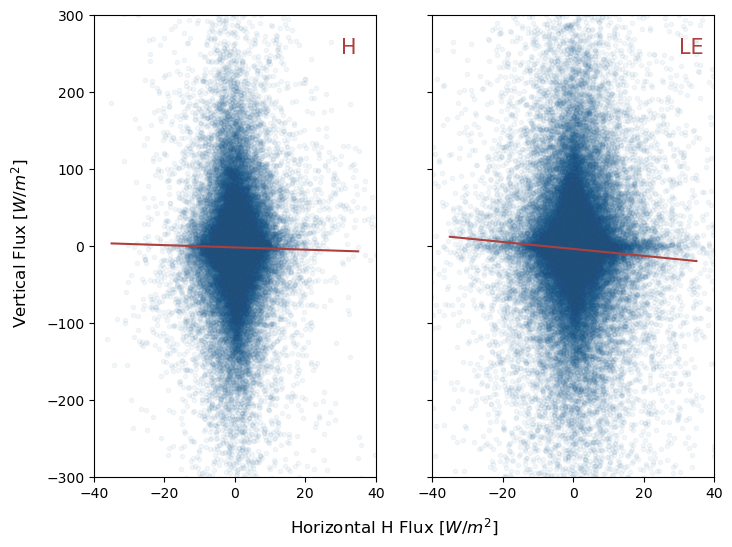

In [121]:
x_11 = np.arange(-35, 40, 70)

fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

#Horizontal Fluxes
x, y = nanfilt(adv_nanfilt.H_hrz.to_numpy().flatten(), adv_nanfilt.H_vert.to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[0].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[0].annotate('H', (30, 250), size = 15, c = colorlist[1])
print('H R2: ', regress[2]**2, regress[0])

#Vertical Fluxes
x, y = nanfilt(adv_nanfilt.LE_hrz.to_numpy().flatten(), adv_nanfilt.LE_vert.to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[1].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[1].annotate('LE', (30, 250), size = 15, c = colorlist[1])


plt.xlim(-40, 40)
plt.ylim(-300, 300)


fig.supxlabel('Horizontal H Flux [$W/m^2$]')
fig.supylabel('Vertical Flux [$W/m^2$]')

plt.savefig('../../Thesis_materials/hrx_v_vert_adv.png')
print('LE R2: ', regress[2]**2, regress[0])

H R2:  0.002719151597533816 0.7001415168130806
LE R2:  0.00022633461610005543 -0.145570955212622


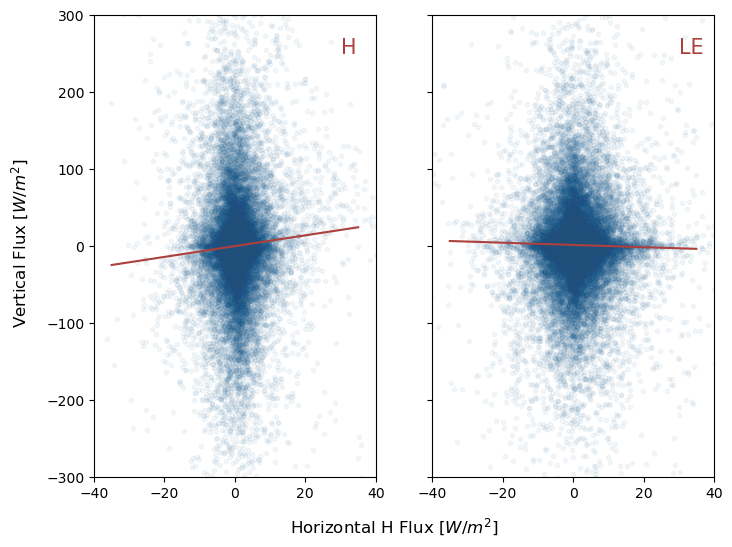

In [122]:
#Stable version

x_11 = np.arange(-35, 40, 70)

fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

#Horizontal Fluxes
x, y = nanfilt(adv_nanfilt.H_hrz.where(MO>0).to_numpy().flatten(), adv_nanfilt.H_vert.where(MO>0).to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[0].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[0].annotate('H', (30, 250), size = 15, c = colorlist[1])
print('H R2: ', regress[2]**2, regress[0])

#Vertical Fluxes
x, y = nanfilt(adv_nanfilt.LE_hrz.where(MO>0).to_numpy().flatten(), adv_nanfilt.LE_vert.where(MO>0).to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[1].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[1].annotate('LE', (30, 250), size = 15, c = colorlist[1])


plt.xlim(-40, 40)
plt.ylim(-300, 300)


fig.supxlabel('Horizontal H Flux [$W/m^2$]')
fig.supylabel('Vertical Flux [$W/m^2$]')

plt.savefig('../../Thesis_materials/hrx_v_vert_adv_st.png')
print('LE R2: ', regress[2]**2, regress[0])

H R2:  0.01621720361747835 -1.9197692842361955
LE R2:  0.003180426836257975 -0.8206990835456367


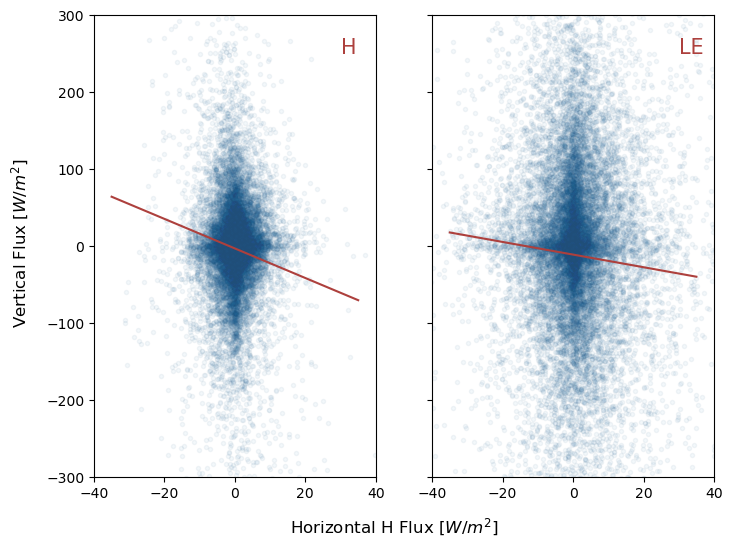

In [123]:
#Untable version

x_11 = np.arange(-35, 40, 70)

fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

#Horizontal Fluxes
x, y = nanfilt(adv_nanfilt.H_hrz.where(MO<0).to_numpy().flatten(), adv_nanfilt.H_vert.where(MO<0).to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[0].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[0].annotate('H', (30, 250), size = 15, c = colorlist[1])
print('H R2: ', regress[2]**2, regress[0])

#Vertical Fluxes
x, y = nanfilt(adv_nanfilt.LE_hrz.where(MO<0).to_numpy().flatten(), adv_nanfilt.LE_vert.where(MO<0).to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[1].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[1].annotate('LE', (30, 250), size = 15, c = colorlist[1])


plt.xlim(-40, 40)
plt.ylim(-300, 300)


fig.supxlabel('Horizontal H Flux [$W/m^2$]')
fig.supylabel('Vertical Flux [$W/m^2$]')

plt.savefig('../../Thesis_materials/hrx_v_vert_adv_Unst.png')
print('LE R2: ', regress[2]**2, regress[0])

(0.09023861983417221, 0.01535066009873165)

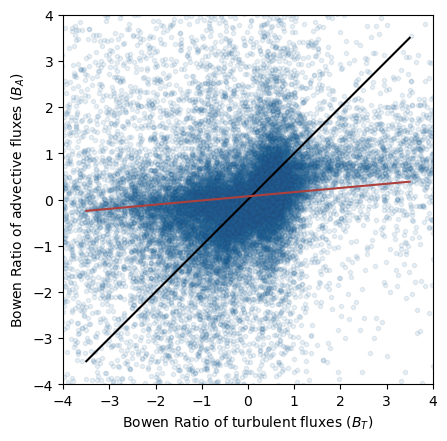

In [156]:
lim = 10 #Lim for Br used in regression
plt_lim = 4 #Lim for plotting
x, y = nanfilt(BR_turb.where((BR_turb<lim)&(BR_turb >-lim)).to_numpy().flatten(), BR_adv.where((BR_adv<lim) &(BR_adv >-lim)).to_numpy().flatten())
# x, y = nanfilt(BR_turb.where((BR_turb<5) &(BR_turb >-5))[tow].to_numpy().flatten(), BR_adv.where((BR_adv<5) &(BR_adv >-5))[tow].to_numpy().flatten())
# plt.hist2d(x, y, range = [[-plt_lim, plt_lim], [-plt_lim, plt_lim]], bins = 50, cmap = 'Blues');


# plt.scatter(x, y, marker = 'o', facecolors='none', edgecolors=colorlist[0], alpha = 0.1);
plt.scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.1);
plt.axis('scaled')

plt.xlim(-plt_lim, plt_lim)
plt.ylim(-plt_lim, plt_lim)
regress = scipy.stats.linregress(x, y)

x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
plt.plot(x_11, x_11, c = 'k')
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
plt.xlabel('Bowen Ratio of turbulent fluxes ($B_T$)')
plt.ylabel('Bowen Ratio of advective fluxes ($B_A$)')


plt.savefig('../../Thesis_materials/BR_turb_adv.png')

regress[0], regress[2]**2

(0.08265115621459977, 0.014850746047368815)

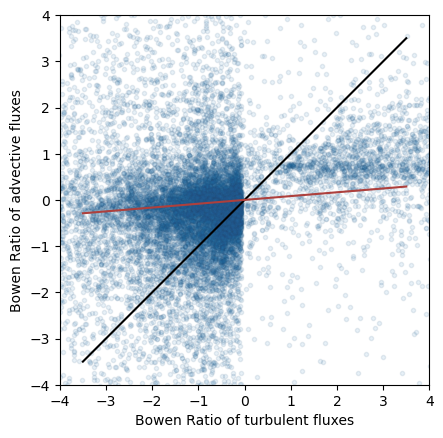

In [125]:
#Stable version
lim = 10 #Lim for Br used in regression
plt_lim = 4 #Lim for plotting
x, y = nanfilt(BR_turb.where((BR_turb<lim)&(BR_turb >-lim)).where(MO>0).to_numpy().flatten(), BR_adv.where((BR_adv<lim) &(BR_adv >-lim)).where(MO>0).to_numpy().flatten())
# x, y = nanfilt(BR_turb.where((BR_turb<5) &(BR_turb >-5))[tow].to_numpy().flatten(), BR_adv.where((BR_adv<5) &(BR_adv >-5))[tow].to_numpy().flatten())
# plt.hist2d(x, y, range = [[-plt_lim, plt_lim], [-plt_lim, plt_lim]], bins = 50, cmap = 'Blues');


# plt.scatter(x, y, marker = 'o', facecolors='none', edgecolors=colorlist[0], alpha = 0.1);
plt.scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.1);
plt.axis('scaled')

plt.xlim(-plt_lim, plt_lim)
plt.ylim(-plt_lim, plt_lim)
regress = scipy.stats.linregress(x, y)

x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
plt.plot(x_11, x_11, c = 'k')
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
plt.xlabel('Bowen Ratio of turbulent fluxes')
plt.ylabel('Bowen Ratio of advective fluxes')


plt.savefig('../../Thesis_materials/BR_turb_adv_st.png')

regress[0], regress[2]**2

(0.07509906091641619, 0.0021183538630864447)

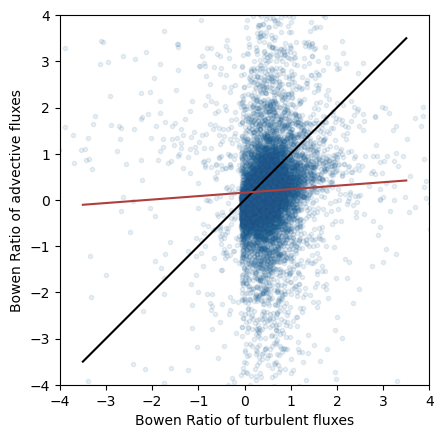

In [126]:
#unstable version
lim = 10 #Lim for Br used in regression
plt_lim = 4 #Lim for plotting
x, y = nanfilt(BR_turb.where((BR_turb<lim)&(BR_turb >-lim)).where(MO<0).to_numpy().flatten(), BR_adv.where((BR_adv<lim) &(BR_adv >-lim)).where(MO<0).to_numpy().flatten())
# x, y = nanfilt(BR_turb.where((BR_turb<5) &(BR_turb >-5))[tow].to_numpy().flatten(), BR_adv.where((BR_adv<5) &(BR_adv >-5))[tow].to_numpy().flatten())
# plt.hist2d(x, y, range = [[-plt_lim, plt_lim], [-plt_lim, plt_lim]], bins = 50, cmap = 'Blues');


# plt.scatter(x, y, marker = 'o', facecolors='none', edgecolors=colorlist[0], alpha = 0.1);
plt.scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.1);
plt.axis('scaled')

plt.xlim(-plt_lim, plt_lim)
plt.ylim(-plt_lim, plt_lim)
regress = scipy.stats.linregress(x, y)

x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
plt.plot(x_11, x_11, c = 'k')
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
plt.xlabel('Bowen Ratio of turbulent fluxes')
plt.ylabel('Bowen Ratio of advective fluxes')


plt.savefig('../../Thesis_materials/BR_turb_adv_unst.png')

regress[0], regress[2]**2

## Contribution of Advective Fluxes to Energy Balance

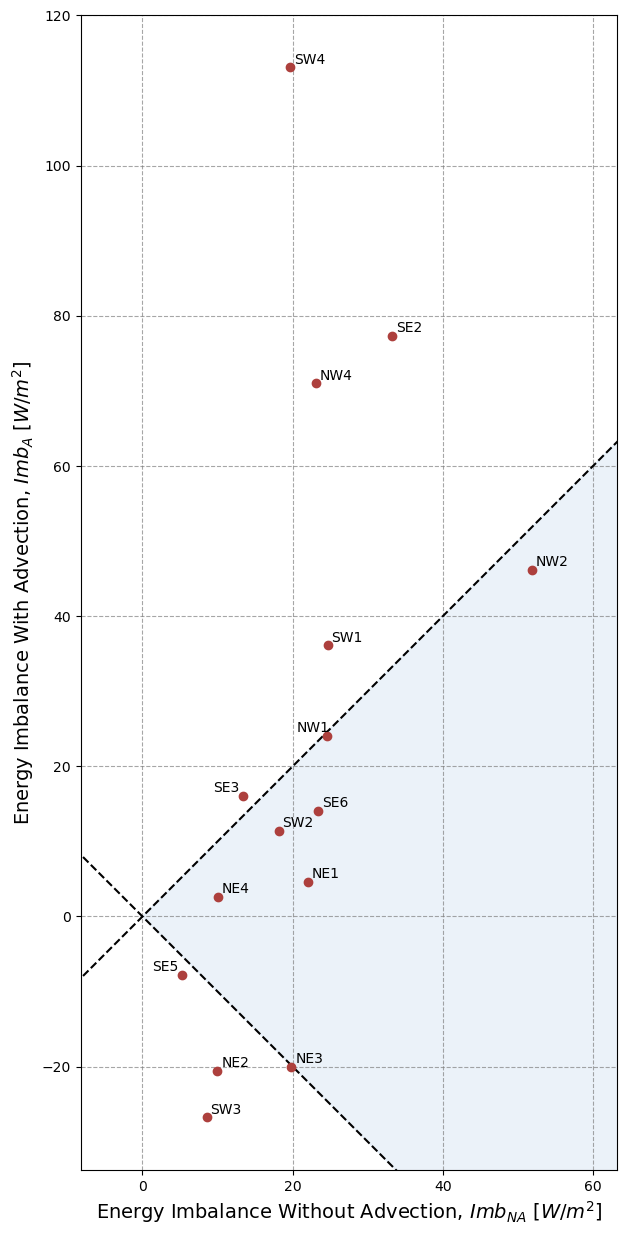

In [163]:
#Scatter plot showing imbalance before and after adcvction included

plt.figure(figsize = (8, 15))

#scatter plot of Imb without advection v. Imb with advection 
for tow in towlist:
    plt.scatter(E_res_na[tow].mean(), E_res_wa[tow].mean(), c = colorlist[1], zorder = 3)
    
    #Lable towers, need to flip side of some labels to not overlap with lines
    if tc.loc[tow].dir_names == 'SE5' or tc.loc[tow].dir_names == 'SE3' or tc.loc[tow].dir_names == 'NW1':
        plt.annotate(tc.loc[tow].dir_names, (E_res_na[tow].mean() - 4, E_res_wa[tow].mean() + 0.5), zorder = 3)
    else:
        plt.annotate(tc.loc[tow].dir_names, (E_res_na[tow].mean() + 0.5, E_res_wa[tow].mean() + 0.5), zorder = 3) 

#A couple points to just make the plot a little wider
plt.scatter(60, 50, c = 'w')
plt.scatter(-5, 50, c = 'w')


plt.xlim(-10, 70)
plt.ylim(-30, 120)

plt.axis('scaled') #Makes scale of x and y same

#plot +/- 1-1 line
x_11 = np.arange(-10, 70, 5) #values for a one-to-one line
plt.plot(x_11, x_11, c = 'k', zorder = 2, linestyle = '--')
plt.plot(x_11, -x_11, c = 'k', zorder = 2, linestyle = '--')

#Fill in area where Imb improves
plt.fill_between(np.arange(0, 90, 5), -np.arange(0, 90, 5), np.arange(0, 90, 5), color=colorlist[5], alpha=0.3, label='Improved Energy Balance', zorder = 1)
# plt.fill_between(np.arange(-10, 90, 5), -np.abs(np.arange(-10, 90, 5)), -np.arange(140, 240, 5), color=colorlist[4], alpha=0.3, label='Improved Energy Balance', zorder = 1)

#Add grid and make xticks same as y 
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
plt.xticks([0, 20, 40, 60]);

#Axes labels
plt.xlabel('Energy Imbalance Without Advection, $Imb_{NA}$ [$W/m^2$]', fontsize = 14)
plt.ylabel('Energy Imbalance With Advection, $Imb_{A}$ [$W/m^2$]', fontsize = 14)
plt.savefig('../../Thesis_materials/Imb_change_lowershade.png')

In [128]:
# EBI by site using average residuals
(E_res_wa.mean() - E_res_na.mean())/E_res_na.mean()

tow
PFA         NaN
PFb   -0.021884
PFc   -0.110116
PFd         NaN
PFe    2.070720
PFg   -0.792223
PFh   -3.065251
PFi   -2.009455
PFj   -0.741969
PFk    0.463565
PFl   -0.370437
PFm   -4.123730
PFn    4.747658
PFp    1.327568
PFq    0.202249
PFr         NaN
PFs   -2.467221
PFt   -0.399211
dtype: float64

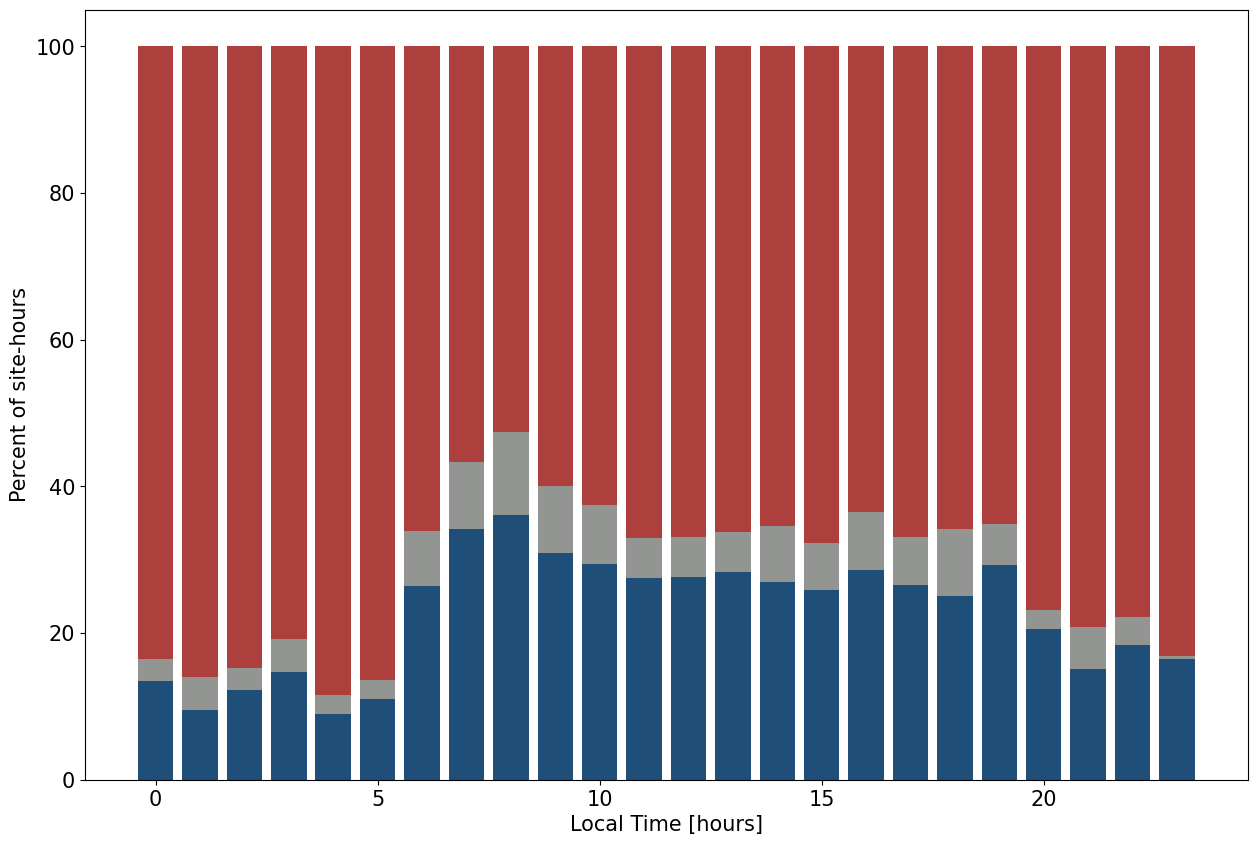

In [129]:
#Calculate Percent of Times Improved
cutoff_perc = 0.1 #Min fractional improvement to be counted as substantial change (0.1 = 10%)
E_res_na_hr = E_res_na.resample('1h').mean()
E_res_wa_hr = E_res_wa.resample('1h').mean()

E_res_na_pos = E_res_na_hr.where(E_res_na_hr>=0) #Only when residual is positive

E_res_impr = (E_res_na_pos.abs() - E_res_wa.abs())/E_res_na_pos.abs()

pos_impr = E_res_impr>cutoff_perc
neg_impr = E_res_impr<-cutoff_perc
no_impr = (E_res_impr<=cutoff_perc)&(E_res_impr>=-cutoff_perc)

pos_impr_count = pos_impr.groupby(pos_impr.index.hour).sum().sum(axis = 1)
neg_impr_count = neg_impr.groupby(neg_impr.index.hour).sum().sum(axis = 1)
no_impr_count = no_impr.groupby(no_impr.index.hour).sum().sum(axis = 1)

all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

pos_impr_perc = pos_impr_count/all_impr_count*100
neg_impr_perc = neg_impr_count/all_impr_count*100
no_impr_perc = no_impr_count/all_impr_count*100

#Plot bar chart of improved times

plt.figure(figsize=(15, 10))
plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc + neg_impr_perc, color = colorlist[1], 
        label = 'Energy residual increased with advection')
plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc, color = colorlist[2], label = 'No significant change')
plt.bar(pos_impr_perc.index, pos_impr_perc, color = colorlist[0], label = 'Energy residual decreased with advection')
# plt.legend(fontsize=15)
plt.xlabel('Local Time [hours]', fontsize=15)
plt.ylabel('Percent of site-hours', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.savefig('../../Thesis_materials/E_bal_impr.png')
# for hour in pos_impr_perc.index:
#     plt.annotate(str(all_impr_count.loc[hour]), (hour-0.5, 100))

In [130]:
#Percent of sites-hours with improved EB
#Change cut_off percent in the cell above to 0 to get percentage improved including <10% improvement
pos_impr_count.sum()/all_impr_count.sum()

0.2550044625780951

In [131]:
#Site hours improved by time of day
pos_impr_perc

TIMESTAMP_START
0     13.529412
1      9.497207
2     12.280702
3     14.743590
4      8.974359
5     10.994764
6     26.446281
7     34.140436
8     36.139630
9     30.857143
10    29.445507
11    27.462121
12    27.651515
13    28.373016
14    26.961771
15    25.902335
16    28.648649
17    26.548673
18    25.102881
19    29.310345
20    20.600858
21    15.111111
22    18.357488
23    16.410256
dtype: float64

# Impact of Environmental Variables on Advection/Energy Balance Improvement

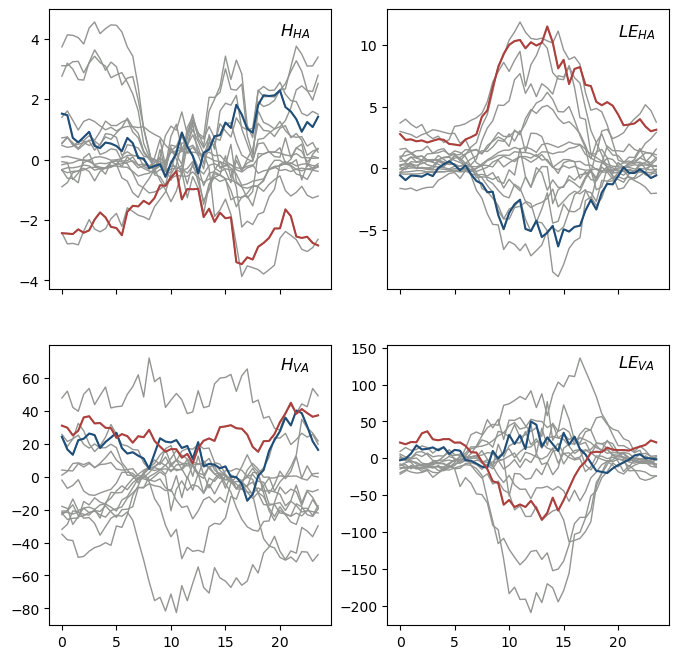

In [ ]:
adv_day = adv_nanfilt.groupby(adv_nanfilt.index.time).mean()
fig, axs = plt.subplots(2, 2, figsize = (8, 8), sharex = True)
# tow = ['PFt']
comp_lab_list = ['$H_{HA}$', '$LE_{HA}$', '$H_{VA}$', '$LE_{VA}$']
for i in range(len(adv_comps)):
    comp = adv_comps[i]
    ax = axs[i//2, i%2]
    for j in range(len(towlist)):
        tow = towlist[j]
        ax.plot(hh_index, adv_day[comp][tow], linewidth = 1, label = tow, c = colorlist[2])#j+6])
    ax.plot(hh_index, adv_day[comp]['PFm'], c = colorlist[0])
    ax.plot(hh_index, adv_day[comp]['PFg'], c = colorlist[1])
    # ax.plot(hh_index, adv_day[comp]['PFc'], c = colorlist[0])
    ax.annotate(comp_lab_list[i], (20, 0.9*adv_day[comp].max().max()), size = 12,  c= 'k')
    
    
# plt.legend()
    
plt.savefig('../../Thesis_materials/adv_comp_diel_cycle.png')

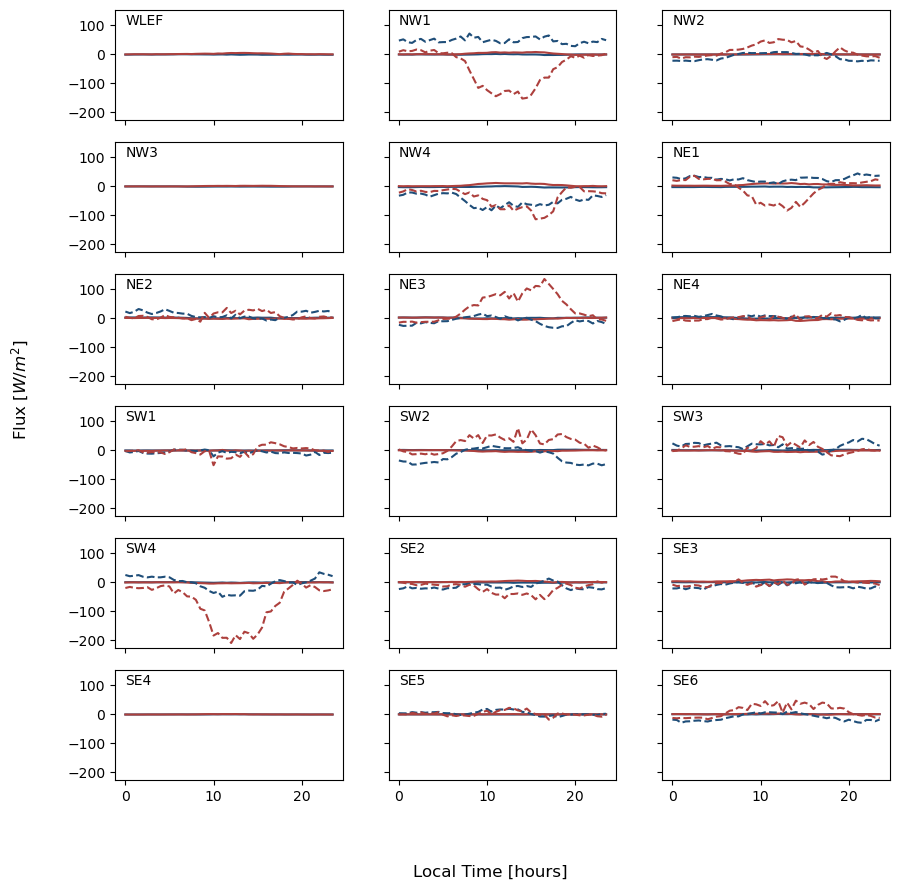

In [133]:

adv_colorlist = [colorlist[0], colorlist[1], colorlist[0], colorlist[1]]
stylelist = ['-', '-', '--', '--']

fig, axs = plt.subplots(6, 3, figsize = [10, 10], sharex=True, sharey=True)
for i in range(len(towlist)):
    tow = towlist[i]
    ax = axs[i//3, i%3]             
    for j in range(len(adv_comps)):
        comp = adv_comps[j]
        ax.plot(hh_index, adv_day[comp][tow].values, c = adv_colorlist[j], linestyle = stylelist[j])
        
    # ax.plot(hh_index, E_budget.H_turb[tow].groupby(E_budget.H_turb.index.time).mean().values, c = colorlist[0], linestyle = 'dotted')
    # ax.plot(hh_index, E_budget.LE_turb[tow].groupby(E_budget.LE_turb.index.time).mean().values, c = colorlist[1], linestyle = 'dotted')
    ax.annotate(tc.dir_names.iloc[i], (0, 100))
    
fig.supylabel('Flux [$W/m^2$]')
fig.supxlabel('Local Time [hours]')
plt.yticks([-200, -100, 0, 100])

plt.savefig('../../Thesis_materials/diurnal_adv_cyc.png')

9.773585114376436 12.873059390329317


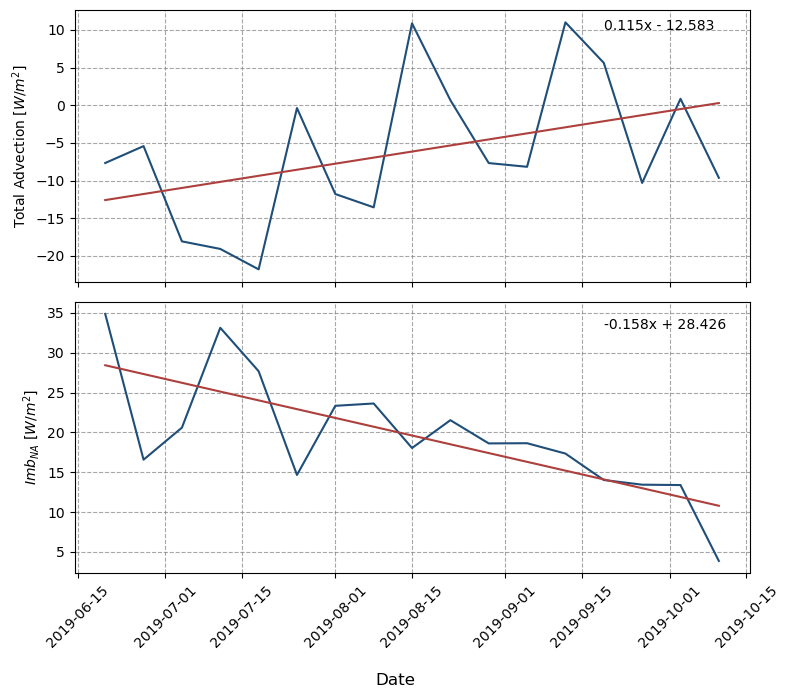

In [134]:
avg_time = '7d'


fig, axs = plt.subplots(2, 1, figsize = (8, 7), sharex = True)

'''advection'''
adv_resamp = adv_total.resample(avg_time).mean().mean(axis = 1)
axs[0].plot(adv_resamp.index, adv_resamp, c = colorlist[0])
x_dt, y = nanfilt(adv_resamp.index, adv_resamp)
x = (x_dt - x_dt[0]).days
regress = scipy.stats.linregress(x, y)
y_bf = regress[0]*x + regress[1]
axs[0].plot(x_dt, y_bf, c = colorlist[1])
axs[0].annotate(str((regress[0]).round(3)) + 'x - ' + str(-regress[1].round(3)), (x_dt[-4], 10))

print(adv_resamp.std(), y_bf[-1] - y_bf[0])

axs[0].set_ylabel('Total Advection [$W/m^2$]')

'''percent site-hours improved'''

# cutoff_perc = 0.1

# pos_impr = E_res_impr>cutoff_perc
# neg_impr = E_res_impr<-cutoff_perc
# no_impr = (E_res_impr<=cutoff_perc)&(E_res_impr>=-cutoff_perc)


# pos_impr_count = pos_impr.resample(avg_time).sum().sum(axis = 1)
# neg_impr_count = neg_impr.resample(avg_time).sum().sum(axis = 1)
# no_impr_count = no_impr.resample(avg_time).sum().sum(axis = 1)
# all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

# pos_impr_perc = pos_impr_count/all_impr_count*100
# axs[1].plot(pos_impr_perc.index, pos_impr_perc, c = colorlist[0])

# pos_impr_count = pos_impr.resample(avg_time).sum().sum(axis = 1)
# pos_impr_perc = pos_impr_count/all_impr_count*100
# x_dt, y = nanfilt(pos_impr_perc.index, pos_impr_perc)
# x = (x_dt - x_dt[0]).days
# regress = scipy.stats.linregress(x, y)
# y_bf = regress[0]*x + regress[1]
# axs[1].plot(x_dt, y_bf, c = colorlist[1])
# axs[1].annotate(str(regress[0].round(3)) + 'x + ' + str(regress[1].round(3)), (x_dt[-24], 60))
# axs[1].set_ylabel('Percent of Site-hours improved')

'''Energy residual'''

E_res_resamp = E_res_na.resample(avg_time).mean().mean(axis = 1)
axs[1].plot(E_res_resamp.index, E_res_resamp, c = colorlist[0])

x_dt, y = nanfilt(E_res_resamp.index, E_res_resamp)
x = (x_dt - x_dt[0]).days
regress = scipy.stats.linregress(x, y)
y_bf = regress[0]*x + regress[1]
axs[1].plot(x_dt, y_bf, c = colorlist[1])
axs[1].annotate(str((regress[0]).round(3)) + 'x + ' + str(regress[1].round(3)), (x_dt[-4], 33))
axs[1].set_ylabel('$Imb_{NA}$ [$W/m^2$]')

'''Adv as percent of res'''

# adv_perc = adv_total/E_res_na*100

# adv_perc_resamp = adv_perc.resample(avg_time).mean().mean(axis = 1)
# # adv_perc_resamp = adv_resamp/E_res_resamp
# axs[2].plot(adv_perc_resamp.index, adv_perc_resamp, c = colorlist[0])
# x_dt, y = nanfilt(adv_perc_resamp.index, adv_perc_resamp)
# x = (x_dt - x_dt[0]).days
# regress = scipy.stats.linregress(x, y)
# y_bf = regress[0]*x + regress[1]
# axs[2].plot(x_dt, y_bf, c = colorlist[1])
# axs[2].annotate(str(regress[0].round(3)) + 'x - ' + str(-regress[1].round(3)), (x_dt[-20], 50))



axs[0].set_ylabel('Total Advection [$W/m^2$]')


axs[0].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
axs[1].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
# axs[2].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
plt.xticks(rotation = 45);

fig.supxlabel('Date')
plt.tight_layout()

plt.savefig('../../Thesis_materials/day_avg_timeseries.png')



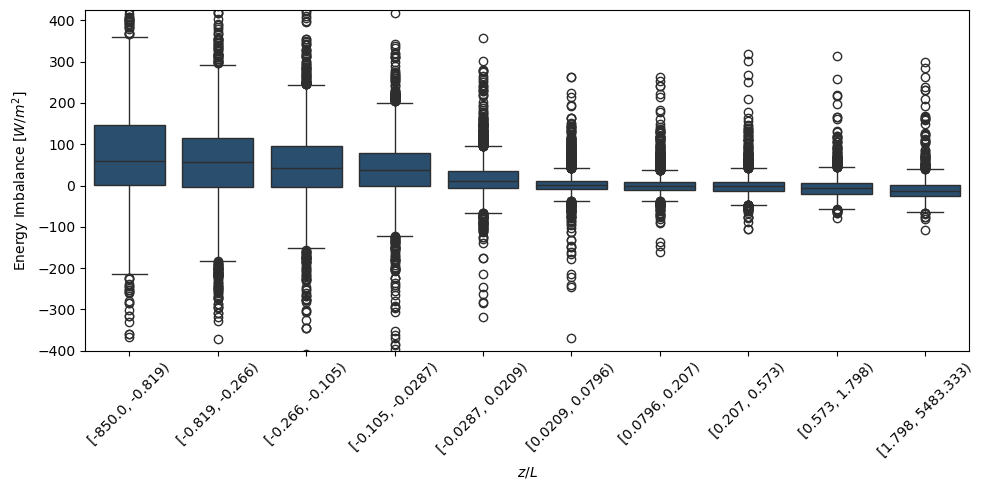

In [135]:
# This is the one that I'm messing with!

E_res_imp = (E_res_na.abs() - E_res_wa.abs())/E_res_na.abs()

x = zeta[np.isfinite(zeta)]
# y = adv_total[np.isfinite(zeta)]
y = E_res_na[np.isfinite(zeta)]



#Find bin edges
x_lin = x.stack(future_stack=True).reset_index()[0]
bins_list = [x_lin.quantile(0)]
for i in np.arange(.1, 1, .1):
    bins_list.append(x_lin.quantile(i))
    
bins_list.append(x_lin.quantile(1))

bins_array = np.array(bins_list)

# Create bins
bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)

y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')

boxplot_data = []
for idx, row in y_grpd.iterrows():
    for value in row['0']:
        boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)
        
fig, axs = plt.subplots(figsize=(10,5))
sns.boxplot(ax = axs, x='Bin', y='Value', data=boxplot_df, color = colorlist[0])

axs.set_xlabel('$z/L$')
axs.set_ylabel('Energy Imbalance [$W/m^2$]')
axs.set_ylim(-400, 425)
axs.tick_params(axis='x', labelrotation=45);

#u* boxplots


x = hrz_wind['Ustar']
# y = adv_total
y = E_res_na


#Find bin edges
x_lin = x.stack(future_stack=True).reset_index()[0]
bins_list = [x_lin.quantile(0)]
for i in np.arange(.1, 1, .1):
    bins_list.append(x_lin.quantile(i))
    
bins_list.append(x_lin.quantile(1))

bins_array = np.array(bins_list)

# Create bins 
bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)


y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')


boxplot_data = []
for idx, row in y_grpd.iterrows():
    for value in row['0']:
        boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)

plt.tight_layout()
# plt.savefig('../../Thesis_materials/atm_var_boxplot.png')




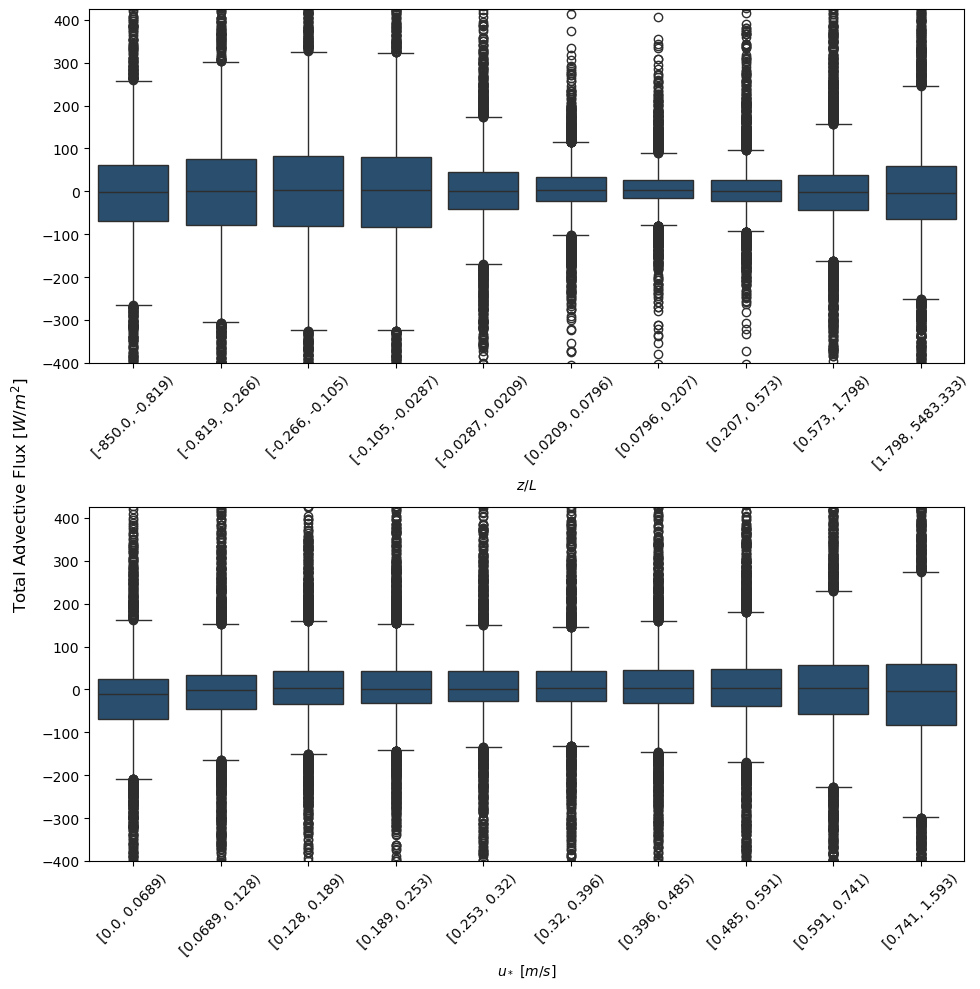

In [136]:
E_res_imp = (E_res_na.abs() - E_res_wa.abs())/E_res_na.abs()

x = zeta[np.isfinite(zeta)]
y = adv_total[np.isfinite(zeta)]


#Find bin edges
x_lin = x.stack(future_stack=True).reset_index()[0]
bins_list = [x_lin.quantile(0)]
for i in np.arange(.1, 1, .1):
    bins_list.append(x_lin.quantile(i))
    
bins_list.append(x_lin.quantile(1))

bins_array = np.array(bins_list)

# Create bins
bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)

y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')

boxplot_data = []
for idx, row in y_grpd.iterrows():
    for value in row['0']:
        boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)
        
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.boxplot(ax = axs[0], x='Bin', y='Value', data=boxplot_df, color = colorlist[0])

axs[0].set_xlabel('$z/L$')
axs[0].set_ylabel('')
axs[0].set_ylim(-400, 425)
axs[0].tick_params(axis='x', labelrotation=45);

#u* boxplots


x = hrz_wind['Ustar']
y = adv_total


#Find bin edges
x_lin = x.stack(future_stack=True).reset_index()[0]
bins_list = [x_lin.quantile(0)]
for i in np.arange(.1, 1, .1):
    bins_list.append(x_lin.quantile(i))
    
bins_list.append(x_lin.quantile(1))

bins_array = np.array(bins_list)

# Create bins 
bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)


y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')


boxplot_data = []
for idx, row in y_grpd.iterrows():
    for value in row['0']:
        boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)

sns.boxplot(ax = axs[1], x='Bin', y='Value', data=boxplot_df, color = colorlist[0])

axs[1].set_xlabel('$u_*$ [$m/s$]')
axs[1].set_ylabel('')
axs[1].set_ylim(-400, 425)
axs[1].tick_params(axis='x', labelrotation=45);


fig.supylabel('Total Advective Flux [$W/m^2$]')
plt.tight_layout()
plt.savefig('../../Thesis_materials/atm_var_boxplot.png')




In [137]:
#Calculate median values of different groups in plot above
np.nanmedian(y_grpd.loc[0].values[1])

-11.672614397459274

## Case Study

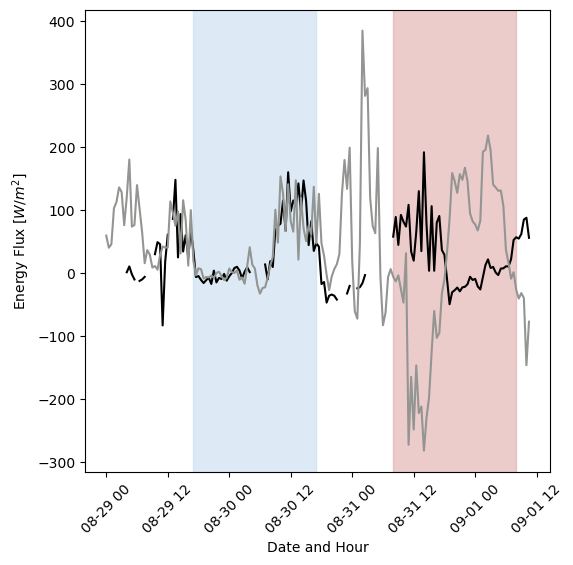

In [138]:
cutstart = dt.datetime(2019, 8, 29)
cutend = dt.datetime(2019, 9, 1, 15)

cutstart_1 = dt.datetime(2019, 8, 29, 17)
cutend_1 = dt.datetime(2019, 8, 30, 17)

cutstart_2 = dt.datetime(2019, 8, 31, 8)
cutend_2 = dt.datetime(2019, 9, 1, 8)

tow = 'PFg'

fig, ax = plt.subplots(1, 1, figsize = [6, 6])

ax.plot(E_res_na[tow][cutstart:cutend], c = 'k')
ax.plot(adv_total[tow][cutstart:cutend], c = colorlist[2])

ax.axvspan(cutstart_1, cutend_1, color=colorlist[5], alpha=0.5)
ax.axvspan(cutstart_2, cutend_2, color=colorlist[6], alpha=0.5)


ax.tick_params(axis='x', labelrotation=45);

ax.set_xlabel('Date and Hour')
ax.set_ylabel('Energy Flux [$W/m^2$]')

plt.savefig('../../Thesis_materials/Case_study_timeseries.png')


                 

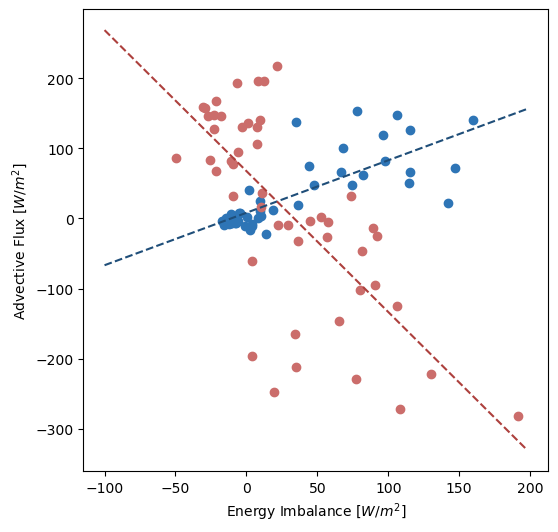

In [139]:
#Ax 2
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.scatter(E_res_na[tow][cutstart_1:cutend_1], adv_total[tow][cutstart_1:cutend_1], c = colorlist[3])
ax.scatter(E_res_na[tow][cutstart_2:cutend_2], adv_total[tow][cutstart_2:cutend_2], c = colorlist[4])

regress_1 = scipy.stats.linregress(nanfilt(E_res_na[tow][cutstart_1:cutend_1], adv_total[tow][cutstart_1:cutend_1]))
regress_2 = scipy.stats.linregress(nanfilt(E_res_na[tow][cutstart_2:cutend_2], adv_total[tow][cutstart_2:cutend_2]))

x = np.arange(-100, 200, 2)
y_1 = regress_1[0]*x + regress_1[1]
y_2 = regress_2[0]*x + regress_2[1]

ax.plot(x, y_1, c = colorlist[0], linestyle = '--')
ax.plot(x, y_2, c = colorlist[1], linestyle = '--')
ax.set_xlabel('Energy Imbalance [$W/m^2$]')
ax.set_ylabel('Advective Flux [$W/m^2$]')


plt.savefig('../../Thesis_materials/Case_study_EBadv_scatter.png')

In [140]:
print(regress_1[0], regress_1[2]**2)
print(regress_2[0], regress_2[2]**2)

0.7481006931380854 0.5846411078084294
-2.0096815765446983 0.5132608543272477


0.8700571640975787


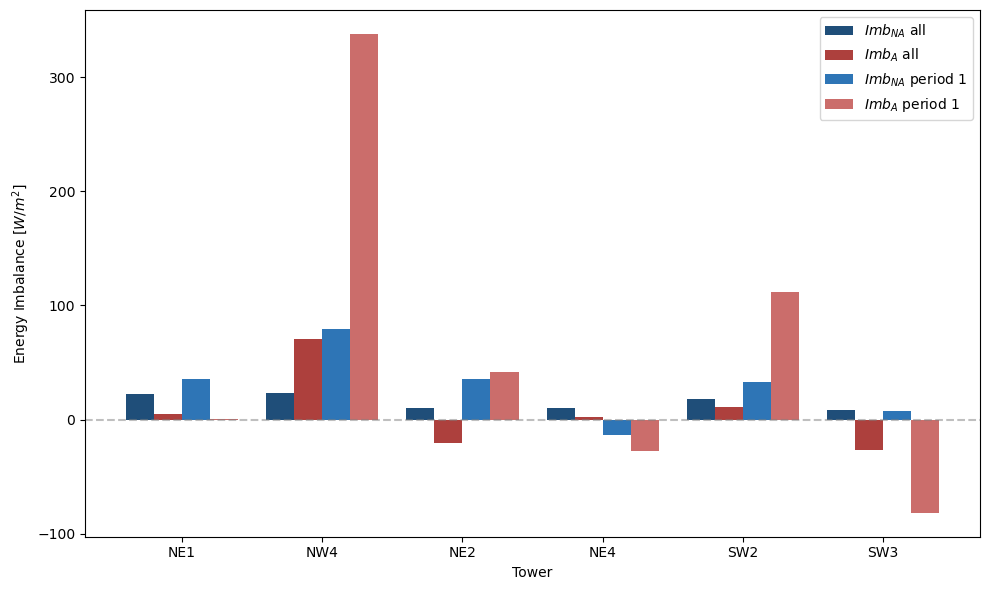

In [141]:
cut_towlist =['PFg', 'PFe', 'PFh', 'PFj', 'PFl', 'PFm']#, 'PFp', 'PFt'] 
cut_towlist_dir = tc.loc[cut_towlist]['dir_names']
colorlist_sub = ['#1F4E79','#AD403D','#2E75B6','#CB6D6B']

Imb_df = pd.DataFrame(index = cut_towlist, columns = ['NA_all', 'WA_all', 'NA_cut', 'WA_cut'])

for tow in cut_towlist:
    Imb_df.loc[tow, 'NA_all'] = E_res_na[tow].mean()
    Imb_df.loc[tow, 'WA_all'] = E_res_wa[tow].mean()
    Imb_df.loc[tow, 'NA_cut'] = E_res_na[cutstart_1:cutend_1][tow].mean()
    Imb_df.loc[tow, 'WA_cut'] = E_res_wa[cutstart_1:cutend_1][tow].mean()
    # Imb_df.loc[tow, 'NA_cut'] = E_res_na[cutstart_2:cutend_2][tow].mean()
    # Imb_df.loc[tow, 'WA_cut'] = E_res_wa[cutstart_2:cutend_2][tow].mean()
 
#Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Number of towers (rows) and number of columns
towers = Imb_df.index
columns = Imb_df.columns
n_towers = len(towers)
n_columns = len(columns)

# Define the width of each bar and create an array for bar positions
bar_width = 0.2
indices = np.arange(n_towers)
labellist = ['$Imb_{NA}$ all', '$Imb_A$ all', '$Imb_{NA}$ period 1', '$Imb_A$ period 1']

# Plot each column as a separate bar
for i, col in enumerate(columns):
    ax.bar(indices + i * bar_width, Imb_df[col], width=bar_width, label=labellist[i], color = colorlist_sub[i])

# Set labels, title, and x-ticks
ax.set_xlabel('Tower')
ax.set_ylabel('Energy Imbalance [$W/m^2$]')
ax.set_xticks(indices + bar_width * (n_columns - 1) / 2)  # Center x-ticks
ax.set_xticklabels(cut_towlist_dir)

# Add a legend
ax.legend()

# Show plot
plt.tight_layout()

plt.axhline(0, color = 'gray', linestyle = '--', alpha = 0.5)

plt.savefig('../../Thesis_materials/Case_study_Res_barchart.png')

print(Imb_df.loc['PFg', 'WA_cut'])


slope: 0.3839726600000206


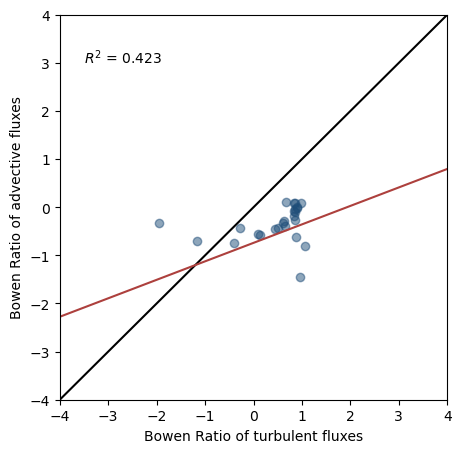

In [142]:
tow = 'PFg'

fig, ax = plt.subplots(1, figsize = (5, 5))

lim = 10 #Lim for Br used in regression
plt_lim = 4 #Lim for plotting

BR_turb_cut = BR_turb[cutstart_1:cutend_1][tow]
BR_adv_cut = BR_adv[cutstart_1:cutend_1][tow]
x, y = nanfilt(BR_turb_cut.where((BR_turb_cut<lim) & (BR_turb_cut>-lim)).to_numpy().flatten(), BR_adv_cut.where((BR_adv_cut<lim) &(BR_adv_cut >-lim)).to_numpy().flatten())
# x, y = nanfilt(BR_turb_cut.to_numpy().flatten(), BR_adv_cut.to_numpy().flatten())


ax.scatter(x, y, c = colorlist[0], alpha = 0.5)
ax.set_xlim(-plt_lim, plt_lim)
ax.set_ylim(-plt_lim, plt_lim)


regress = scipy.stats.linregress(x, y)
plt_lim = 10

x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
ax.plot(x_11, x_11, c = 'k')
ax.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax.set_xlabel('Bowen Ratio of turbulent fluxes')
ax.set_ylabel('Bowen Ratio of advective fluxes')

ax.annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-3.5, 3))

print('slope:', regress[0])
plt.savefig('../../Thesis_materials/NE1P1_BR_scatter.png')


H R2:  0.18917313740420172
LE R2:  0.0008538780244254906


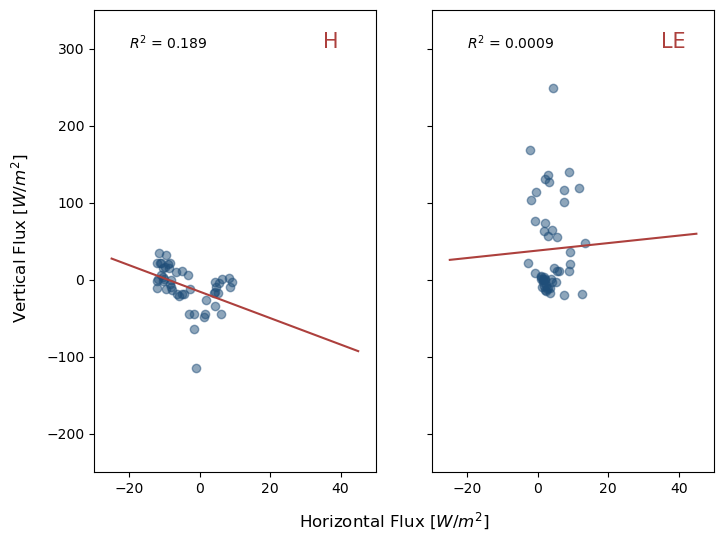

In [143]:
'''Hrz v vert advective fluxes'''

x_11 = np.arange(-25, 50, 70)

fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

adv_cut = adv_nanfilt[cutstart_1:cutend_1]

#Horizontal Fluxes
x, y = nanfilt(adv_cut.H_hrz[tow].to_numpy().flatten(), adv_cut.H_vert[tow].to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[0].scatter(x, y, c=colorlist[0], alpha = 0.5);
ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[0].annotate('H', (35, 300), size = 15, c = colorlist[1])
print('H R2: ', regress[2]**2)
ax[0].annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-20, 300))

#Vertical Fluxes
x, y = nanfilt(adv_cut.LE_hrz[tow].to_numpy().flatten(), adv_cut.LE_vert[tow].to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[1].scatter(x, y, c=colorlist[0], alpha = 0.5);
ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[1].annotate('LE', (35, 300), size = 15, c = colorlist[1])
ax[1].annotate('$R^2$ = ' + str((regress[2]**2).round(4)), (-20, 300))

plt.xlim(-30, 50)
plt.ylim(-250, 350)


fig.supxlabel('Horizontal Flux [$W/m^2$]')
fig.supylabel('Vertical Flux [$W/m^2$]')

plt.savefig('../../Thesis_materials/hrz_v_vert_adv_NE1P1.png')
print('LE R2: ', regress[2]**2)






## Sensitivity Analysis

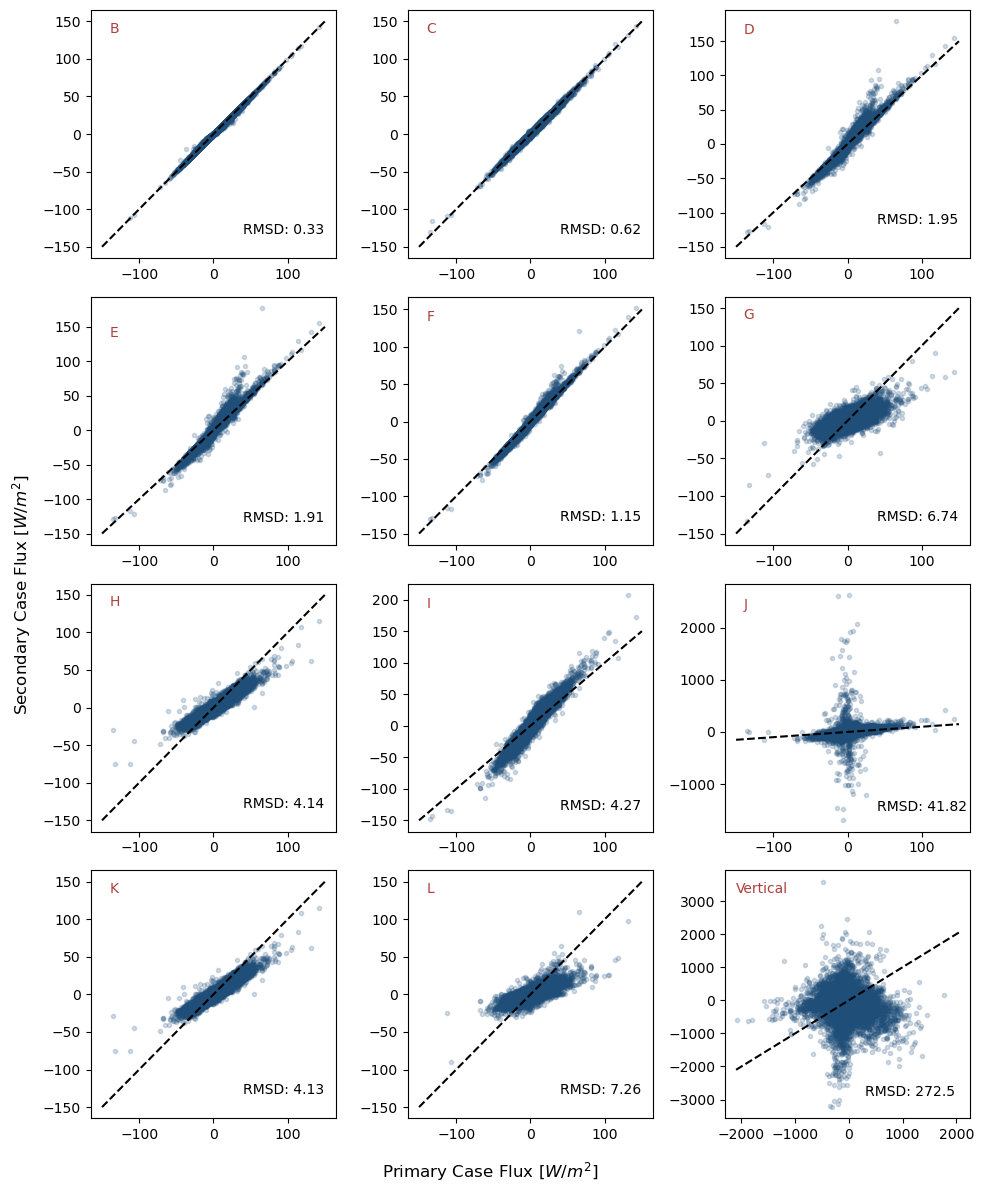

In [144]:
hrz_tot_A = H_hrz['A'].where(nancount.max(axis = 1)<=towsmin) + LE_hrz['A'].where(nancount.max(axis = 1)<=towsmin)
vert_tot_son = vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin) + vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin)
vert_tot_cont = vert_ad_cont['H'].where(nancount.max(axis = 1)<=towsmin) + vert_ad_cont['H'].where(nancount.max(axis = 1)<=towsmin)

fig, axs = plt.subplots(4, 3, figsize = (10, 12))
RMSD = pd.DataFrame(index = cases.index[1:], columns = ['RMSD'])

for i in range(len(cases.index[1:])):
    case = cases.index[i+1]
    ax = axs[i//3, i%3]
    hrz_tot = H_hrz[case].where(nancount.max(axis = 1)<=towsmin) + LE_hrz[case].where(nancount.max(axis = 1)<=towsmin)
    ax.scatter(hrz_tot_A, hrz_tot, marker = '.', c = colorlist[0], alpha = 0.2)
    RMSD_case  = (((hrz_tot_A - hrz_tot)**2).mean().mean())**(1/2)
    RMSD.loc[case, 'RMSD'] = RMSD_case 
    
    if case == 'I' or case == 'J' or case == 'D':
        ax.annotate(case, (-140, hrz_tot.max().max()*0.9), fontsize = 10, c = colorlist[1])
        ax.annotate('RMSD: ' + str(round(RMSD_case, 2)), (40, hrz_tot.min().min()*0.9), fontsize = 10)
    else:
        ax.annotate(case, (-140, 135), fontsize = 10, c = colorlist[1])
        ax.annotate('RMSD: ' + str(round(RMSD_case, 2)), (40, -133), fontsize = 10)
    x11 = np.arange(-150, 200, 50)
    ax.plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)
    
    
axs[3, 2].scatter(vert_tot_son, vert_tot_cont, marker = '.', c = colorlist[0], alpha = 0.2)
RMSD_case  = (((vert_tot_son - vert_tot_cont)**2).mean().mean())**(1/2)
axs[3, 2].annotate('RMSD: ' + str(round(RMSD_case, 1)), (300, vert_tot_cont.min().min()*0.9), fontsize = 10)
axs[3, 2].annotate('Vertical', (-2100, vert_tot_cont.max().max()*0.9), fontsize = 10, c = colorlist[1])
x11 = np.arange(-2100, 2100, 50)
axs[3, 2].plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)

fig.supxlabel('Primary Case Flux [$W/m^2$]')
fig.supylabel('Secondary Case Flux [$W/m^2$]')

plt.tight_layout()
plt.savefig('../../Thesis_materials/sensitivity_anals_scatter.png')

In [145]:
vert_tot_cont.stack().std(), vert_tot_son.stack().std()

(203.43285510822355, 149.91667035570848)

In [146]:
cases

grad_method  interp_dist interp_dir      interp_kernel stability
case                                                                 
A         interp       1000.0     updown  thin_plate_spline       NaN
B         interp       1000.0     updown  thin_plate_spline    Benoit
C         interp       1000.0       NSEW  thin_plate_spline       NaN
D         interp         10.0     updown  thin_plate_spline       NaN
E         interp        100.0     updown  thin_plate_spline       NaN
F         interp        500.0     updown  thin_plate_spline       NaN
G         interp       5000.0     updown  thin_plate_spline       NaN
H         interp       1000.0     updown             linear       NaN
I         interp       1000.0     updown              cubic       NaN
J         interp       1000.0     updown            quintic       NaN
K         interp       1000.0     updown       multiquadric       NaN
L        gradavg          NaN        NaN                NaN       NaN

Text(0, 0.5, 'Energy Flux [$W/m^2$]')

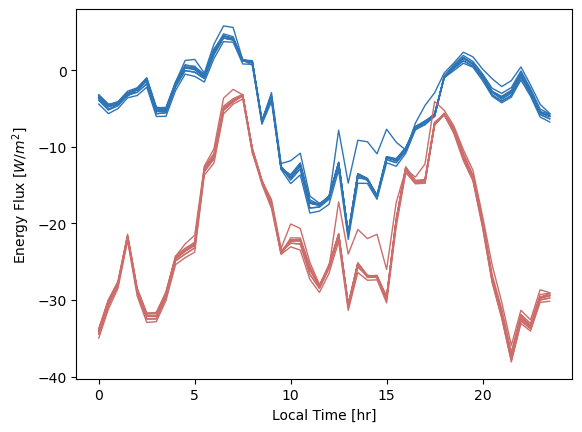

In [147]:

caselist = cases.index
diurnal_all_case_son = pd.DataFrame()
diurnal_all_case_cont = pd.DataFrame()
hrz_all_case = H_hrz.groupby(H_hrz.index.time).mean() + LE_hrz.groupby(H_hrz.index.time).mean()

vert_son_day = vert_ad_son.groupby(vert_ad_son.index.time).mean()
vert_cont_day = vert_ad_cont.groupby(vert_ad_cont.index.time).mean()

for case in cases.index:
    diurnal_all_case_son[case] = (hrz_all_case[case] + vert_son_day['H'] + vert_son_day['LE']).mean(axis = 1)
    diurnal_all_case_cont[case] = (hrz_all_case[case] + vert_cont_day['H'] + vert_cont_day['LE']).mean(axis = 1)

plt.plot(hh_index, diurnal_all_case_son, c = colorlist[3], linewidth = 1, alpha = 1);
plt.plot(hh_index, diurnal_all_case_cont, c = colorlist[4], linewidth = 1, alpha = 1);
# plt.plot(hh_index, E_res_na.groupby(E_res_na.index.time).mean().mean(axis = 1), c = 'k');

plt.xlabel('Local Time [hr]')
plt.ylabel('Energy Flux [$W/m^2$]')
# plt.savefig('../../Thesis_materials/all_cases_diel.png')

In [148]:
pos_impr_perc

TIMESTAMP_START
0     13.529412
1      9.497207
2     12.280702
3     14.743590
4      8.974359
5     10.994764
6     26.446281
7     34.140436
8     36.139630
9     30.857143
10    29.445507
11    27.462121
12    27.651515
13    28.373016
14    26.961771
15    25.902335
16    28.648649
17    26.548673
18    25.102881
19    29.310345
20    20.600858
21    15.111111
22    18.357488
23    16.410256
dtype: float64

In [149]:
hrz_tot_A.mean()

tow
PFA    1.223709
PFb    1.873118
PFc    0.113469
PFd    0.235197
PFe    2.148456
PFg    3.219293
PFh    1.723925
PFi    2.222938
PFj    0.223287
PFk   -0.958033
PFl   -0.113875
PFm   -1.083538
PFn   -0.884708
PFp    1.878243
PFq    4.975969
PFr   -0.147414
PFs    0.203323
PFt    1.390538
dtype: float64

R2 0.07666740925500551


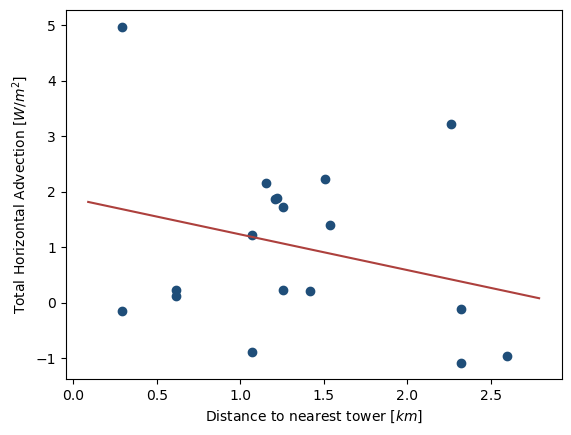

In [150]:
tow_dists = pd.DataFrame(index = towlist, columns = towlist)
for tow in towlist:
    tow_dists[tow] = ((tc.loc[tow].x - tc.x)**2 + (tc.loc[tow].y - tc.y)**2)**(1/2)
tow_dist_mins = tow_dists.where(tow_dists>0).min()/1000

pos_impr_count = pos_impr.sum()
no_impr_count = no_impr.sum()
neg_impr_count = neg_impr.sum()

all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

pos_impr_perc = pos_impr_count/all_impr_count*100

x, y = nanfilt(tow_dist_mins, pos_impr_perc)
x, y = nanfilt(tow_dist_mins, hrz_tot_A.mean())

# plt.scatter(tow_dist_mins, (E_res_na.mean().abs() - E_res_wa.mean().abs())/E_res_na.mean().abs())
plt.scatter(x, y, c = colorlist[0])


regress = scipy.stats.linregress(x, y)
x_11 = np.arange(x.min()-0.2, x.max() +0.2, .1)
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])


plt.annotate(str((regress[0]).round(3)) + 'x + ' + str(regress[1].round(3)), (2.12, 40))
plt.xlabel('Distance to nearest tower [$km$]')
# plt.ylabel('Percent of site-hours improved')
plt.ylabel('Total Horizontal Advection [$W/m^2$]')
print('R2', regress[2]**2)
plt.savefig('../../Thesis_materials/tow_dist_adv.png')

# Slide Figures

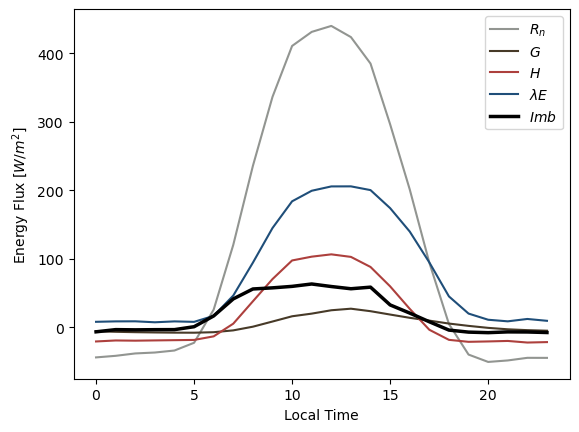

In [151]:

plt.plot(E_budget.Rnet.groupby(E_budget.index.hour).mean().mean(axis = 1), c = colorlist[2], label = '$R_n$')
plt.plot(E_budget.G.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#473a28', label = '$G$')
plt.plot(E_budget.H_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c= colorlist[1], label = '$H$')
plt.plot(E_budget.LE_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c = colorlist[0], label = '$\lambda E$')
plt.plot(E_res_na.groupby(E_res_na.index.hour).mean().mean(axis = 1), 'k', label = '$Imb$', linewidth = 2.5)

plt.xlabel('Local Time')
plt.ylabel('Energy Flux [$W/m^2$]')
plt.legend()

plt.savefig('../../Thesis_materials/d_cyc_ebal_comps_thesisv.png')


# E_res_na_all = E_budget.Rnet - E_budget.G - E_budget.H_turb - E_budget.LE_turb - E_budget.SH - E_budget.SLE  + E_budget.SG

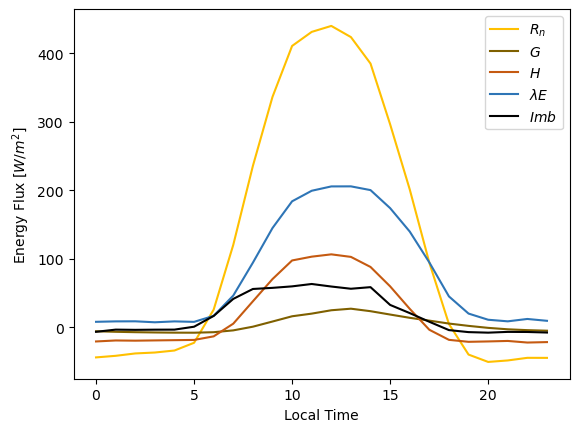

In [152]:

plt.plot(E_budget.Rnet.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#FFC000', label = '$R_n$')
plt.plot(E_budget.G.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#7F6000', label = '$G$')
plt.plot(E_budget.H_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c= '#C55A11', label = '$H$')
plt.plot(E_budget.LE_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#2E75B6', label = '$\lambda E$')
plt.plot(E_res_na.groupby(E_res_na.index.hour).mean().mean(axis = 1), 'k', label = '$Imb$')

plt.xlabel('Local Time')
plt.ylabel('Energy Flux [$W/m^2$]')
plt.legend()

plt.savefig('../../Thesis_materials/d_cyc_ebal_comps.png')


# E_res_na_all = E_budget.Rnet - E_budget.G - E_budget.H_turb - E_budget.LE_turb - E_budget.SH - E_budget.SLE  + E_budget.SG

## Appendix Table

In [153]:
    # A & Interpolation & 1000 & Upwind/ downwind & thin\_plate\_spline & None \\ \hline
    
c_tab = pd.read_csv('../../Thesis_materials/Appendix_table.csv')

In [154]:
tab_code = '' #Code to make table
c_col_list = c_tab.columns #lit of columns in c_tab
for row in c_tab.index:
    case_string = '' #String for the row
    case_line = c_tab.loc[row]
    for col in c_col_list:
        case_string += str(case_line[col])
        if col != c_col_list[-1]:
            case_string += ' & '
    if row != c_tab.index[-1]:
        case_string += '\\\ \hline' + ' '
    tab_code += case_string
    

In [155]:
print(tab_code)

1 & Interpo\-lation & 10 & Upwind\/ Downwind & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 2 & Interpo\-lation & 100 & Upwind\/ Downwind & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 3 & Interpo\-lation & 500 & Upwind\/ Downwind & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 4 & Interpo\-lation & 1000 & Upwind\/ Downwind & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 5 & Interpo\-lation & 5000 & Upwind\/ Downwind & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 6 & Interpo\-lation & 10 & N\/S\/E\/W & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 7 & Interpo\-lation & 100 & N\/S\/E\/W & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 8 & Interpo\-lation & 500 & N\/S\/E\/W & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 9 & Interpo\-lation & 1000 & N\/S\/E\/W & thin\_plate\-\_spline & Benoit (1977) & Sonic Anemometer\\ \hline 1